In [1]:
# toc (adds a table of contents)
from typing import Callable, List, Iterable

import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import pandas as pd

plt.style.use('../maroon_ipynb.mplstyle')  # applies MSU theme to plots

# Problem 1
## Given

$$
\frac{d^2 x}{d t^2}-\mu\left(1-x^2\right) \frac{d x}{d t}+x-A \sin (\omega t)=0
$$

where $\mu=1$, $\omega=\frac{2\pi}{10}$, and $A=10$

## Find
From the differential equation above,

a. Find the state variable form.
b. Use Euler's Explicit method to obtain a numerical solution of the state variable equations from part (a). Assume zero initial conditions and that $t\le20$. Find the smallest value of $\Delta t$ that gives a converged solution (solution doesn't change as time step decreases).
c. Repeat part (b) using a fourth order runge kutta solver with a fixed time step.
d. The results in parts (b) and (c) should be the same, but the value of $\Delta t$ chosen for (c) should be smaller than that for part (b). If the method used in part (c) requires four times the computational resources per time step, compare the computational resources for each case.

## Solution
### Part A

In [2]:
mu_, omega_, A_ = 1, 2*np.pi/10, 10  # constants (units not given)

# Defining the ODE
t, mu, omega, A = sp.symbols('t mu omega A')
x0 = sp.Function('x_0')(t)

eq = sp.Eq(x0.diff(t, 2) - mu*(1 - x0**2)*x0.diff(t) + x0 - A*sp.sin(omega*t), 0)
eq

Eq(-A*sin(omega*t) - mu*(1 - x_0(t)**2)*Derivative(x_0(t), t) + x_0(t) + Derivative(x_0(t), (t, 2)), 0)

This is a just a single second order ODE, so it only requires one state variable to make a system of first order ODEs.

In [3]:
# Define the new state variable
x1 = sp.Function('x_1')(t)

# Add the new state variable as the second equation
eq2 = sp.Eq(x1, x0.diff(t))

# Substitute the second state variable into the original equation
eq1 = eq.subs(x0.diff(t), x1)
display(eq1, eq2)

Eq(-A*sin(omega*t) - mu*(1 - x_0(t)**2)*x_1(t) + x_0(t) + Derivative(x_1(t), t), 0)

Eq(x_1(t), Derivative(x_0(t), t))

In [4]:
# Solve the system of equations
sol = sp.solve([eq1, eq2], [x0.diff(), x1.diff()], dict=True)[0]
for key, value in sol.items():
    display(sp.Eq(key, value))

Eq(Derivative(x_0(t), t), x_1(t))

Eq(Derivative(x_1(t), t), A*sin(omega*t) - mu*x_0(t)**2*x_1(t) + mu*x_1(t) - x_0(t))

As seen above, only first order derivatives are on the left hand side, and the instantaneous states are on the right hand side. This is the state variable form, but we can just manually write the python function for numerical use with how simple this is. For more complex problems, you can automate the conversion from `sympy` operations to python or `numpy` operations by using the `lambdify` function.

In [5]:
# Defining state variable function
def state_vars(x, t_):
    return [
        x[1],
        A_*np.sin(omega_*t_) - mu_*x[0]**2*x[1] + mu_*x[1] - x[0]
    ]

### Part B
The below code cell is the routine for Euler's Explicit method and takes into account any number of ODE's.

In [6]:
def euler_explicit(func: Callable, y0: List | Iterable, t_values: List | Iterable) -> List:
    n = len(func(y0, t_values[0]))
    arrays = [[y0_] for y0_ in y0]

    for i in range(len(t_values) - 1):
        h = t_values[i + 1] - t_values[i]
        current_state = [array[-1] for array in arrays]
        derivatives = func(current_state, t_values[i])
        for j in range(n):
            arrays[j].append(arrays[j][-1] + h*derivatives[j])

    return arrays

To measure the error of the Euler's Explicit method, we can compare it to the `scipy` solution using the `odeint` function. We can assume that the `scipy` solution is the true solution and the error will be determined by

$$err=max(|x_{num} - x_{exact}|)$$

We will choose the time step that gives $err<10^{-3}$.

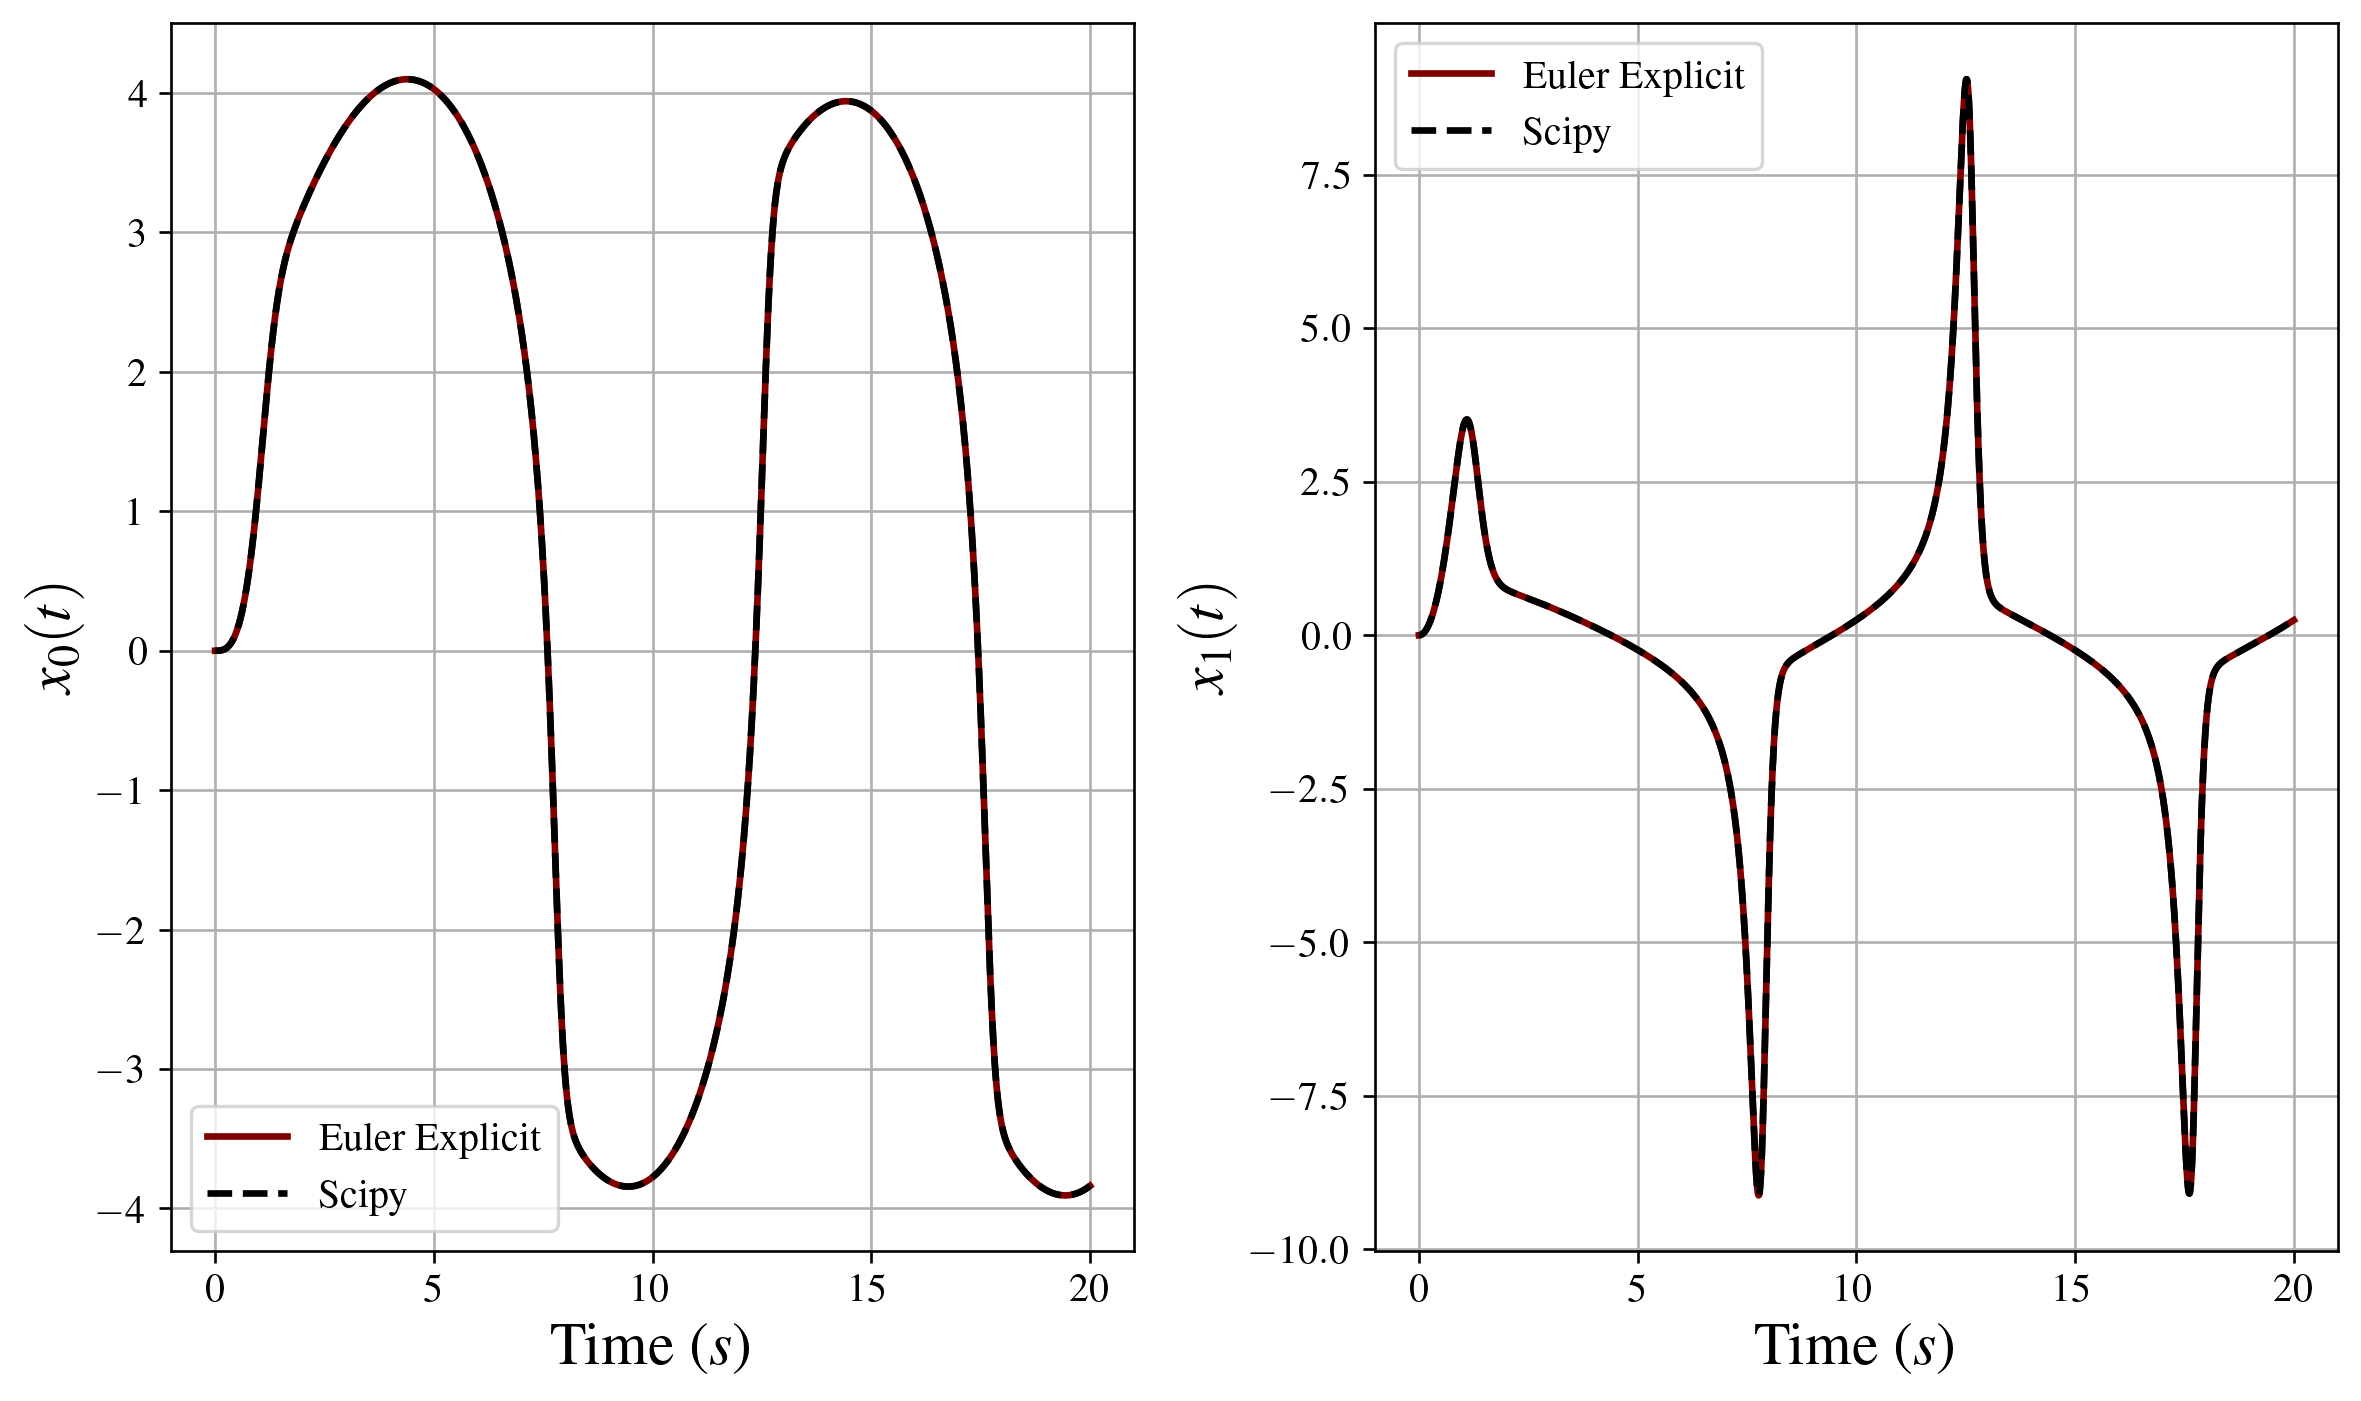

In [7]:
err = 1
del_t = 0.1
t_array, x0_euler, x1_euler, scipy_sol = None, None, None, None
while err > 1e-3:
    del_t /= 2
    t_array = np.arange(0, 20, del_t)
    sol = euler_explicit(state_vars, [0, 0], t_array)
    scipy_sol = odeint(state_vars, [0, 0], t_array)
    x0_euler, x1_euler = np.array(sol[0]), np.array(sol[1])
    err = np.max(np.abs(x0_euler - scipy_sol[:, 0]))

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(t_array, x0_euler, label='Euler Explicit')
ax[0].plot(t_array, scipy_sol[:, 0], label='Scipy', ls='--')
ax[1].plot(t_array, x1_euler, label='Euler Explicit')
ax[1].plot(t_array, scipy_sol[:, 1], label='Scipy', ls='--')
ax[0].set_ylabel('$x_0(t)$')
ax[1].set_ylabel('$x_1(t)$')
ax[0].set_xlabel('Time ($s$)')
ax[1].set_xlabel('Time ($s$)')
ax[0].legend()
ax[1].legend()
plt.show()

In [8]:
del_t_euler = del_t
del_t_euler # resulting time step used above

2.44140625e-05

### Part C
Similarly to Part B, here is the routine for the fourth order Runge-Kutta method.

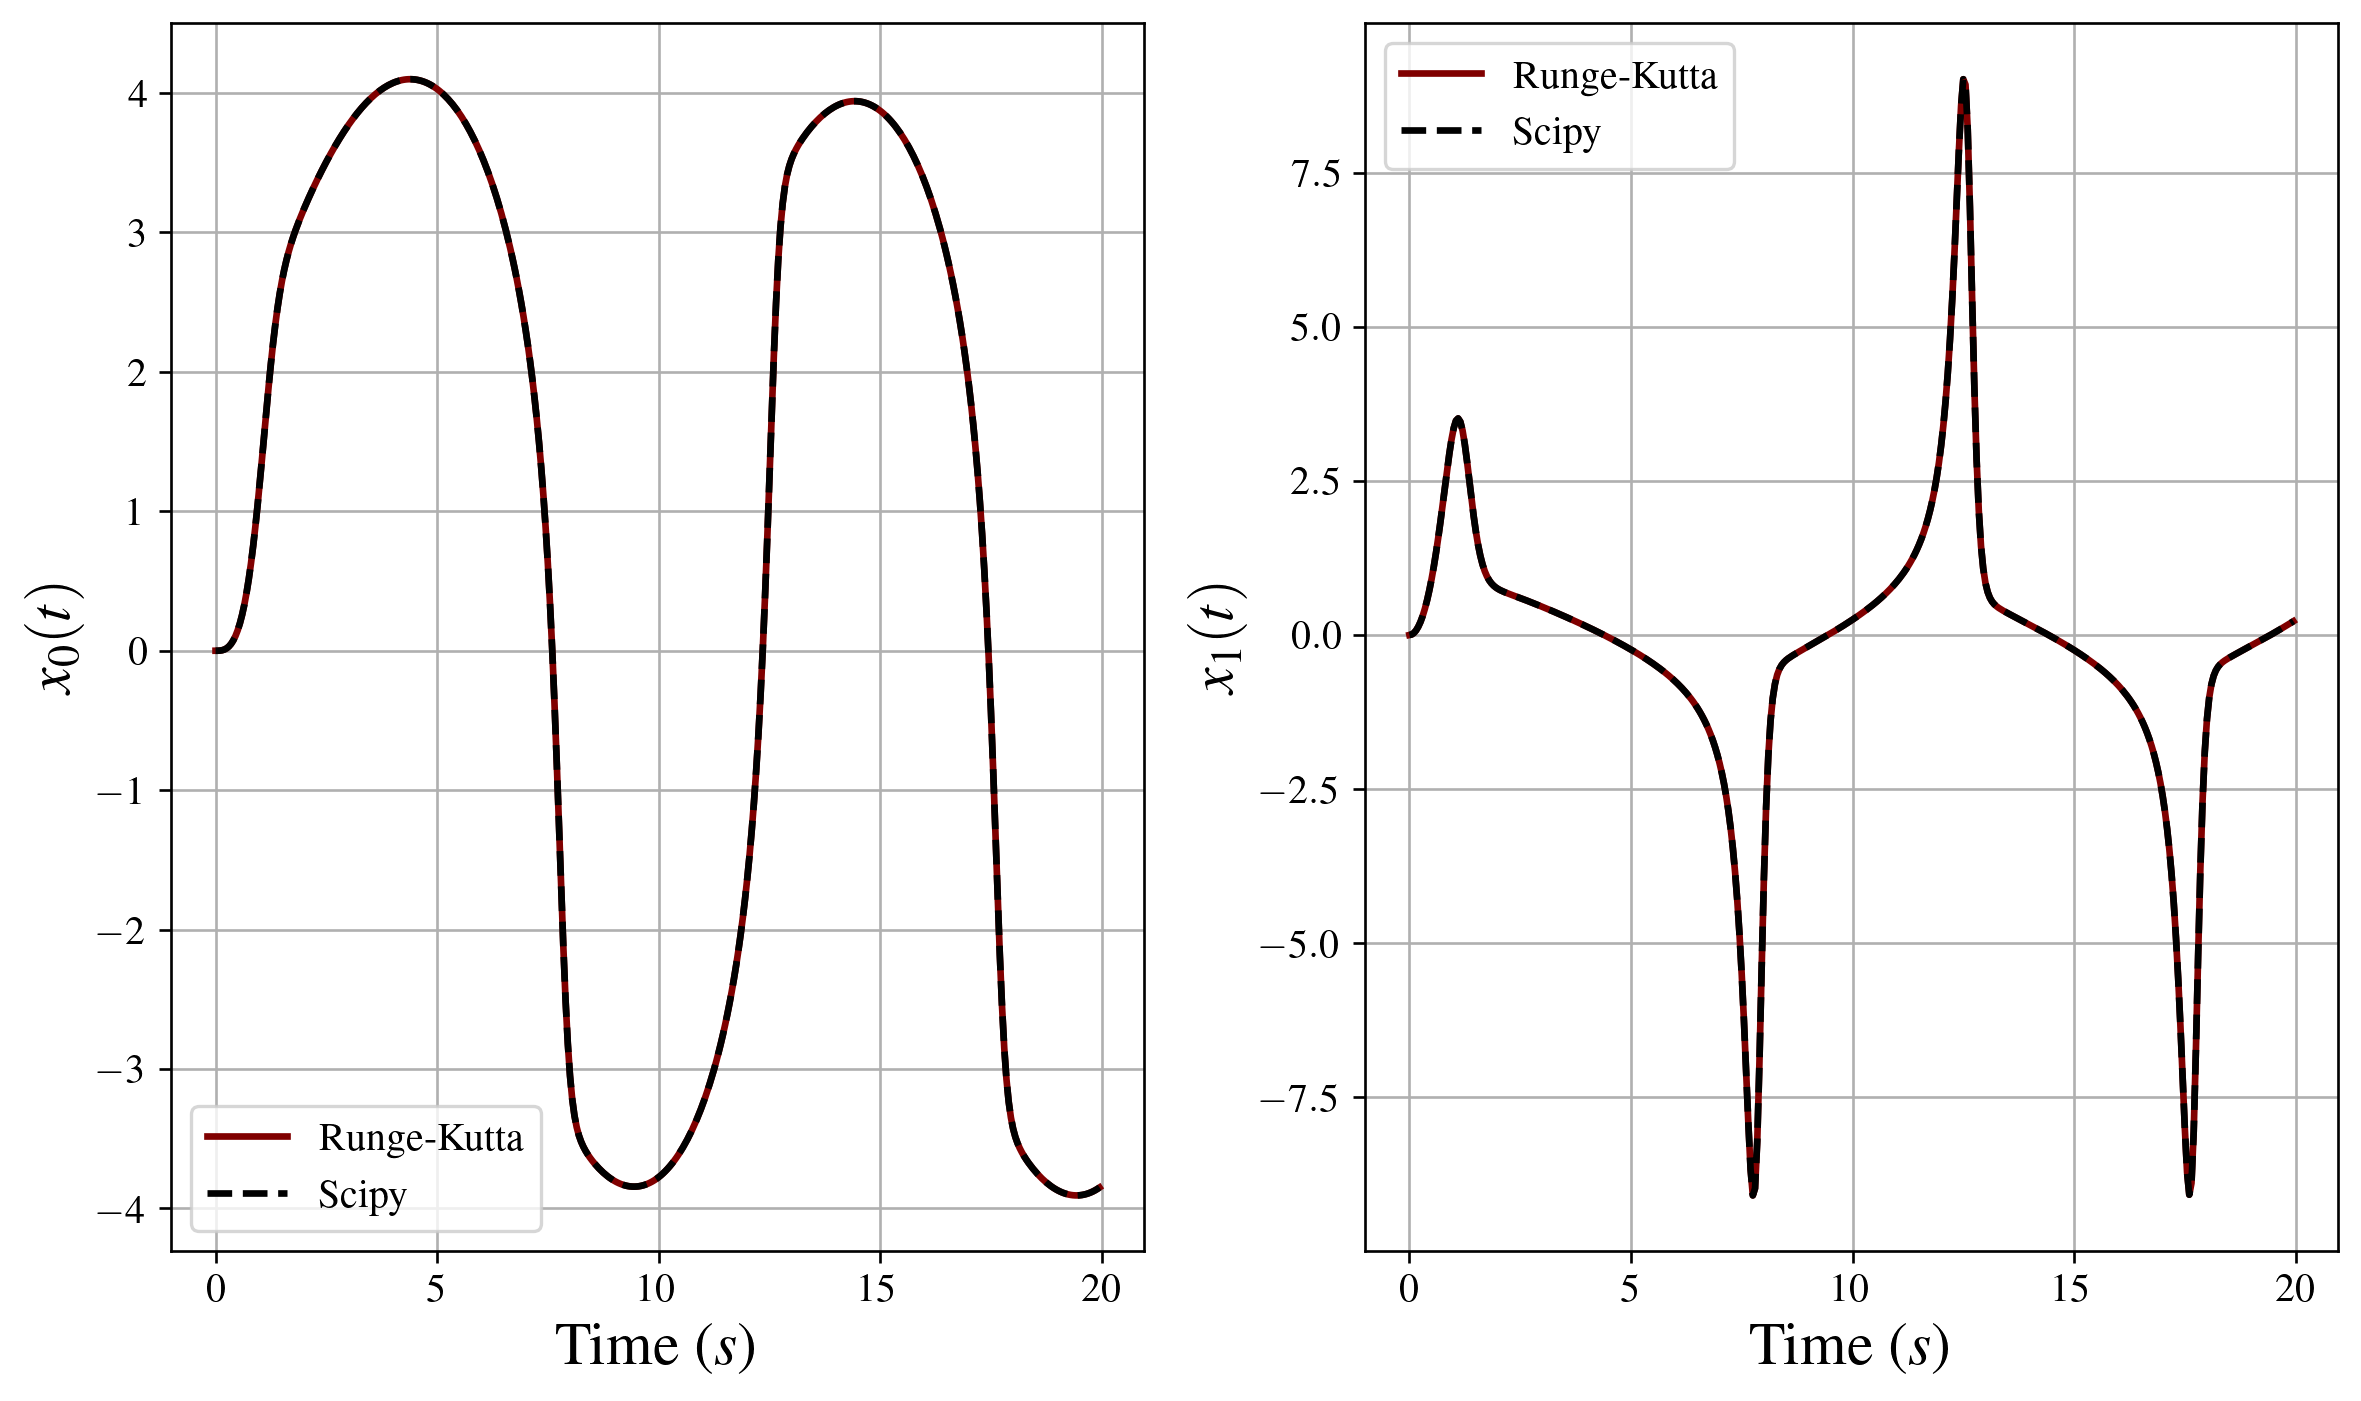

In [9]:
def runge_kutta(func: Callable, y0: List | Iterable, t_values: List | Iterable) -> List:
    n = len(func(y0, t_values[0]))
    arrays = [[y0_] for y0_ in y0]

    for i in range(len(t_values) - 1):
        h = t_values[i + 1] - t_values[i]
        K1 = func([array[i] for array in arrays], t_values[i])
        K2 = func([array[i] + 0.5*h*K for array, K in zip(arrays, K1)], t_values[i] + 0.5*h)
        K3 = func([array[i] + 0.5*h*K for array, K in zip(arrays, K2)], t_values[i] + 0.5*h)
        K4 = func([array[i] + h*K for array, K in zip(arrays, K3)], t_values[i] + h)

        for j in range(n):
            arrays[j].append(arrays[j][i] + h/6*(K1[j] + 2*K2[j] + 2*K3[j] + K4[j]))

    return arrays

err = 1
del_t = 0.1
t_array, x0_rk, x1_rk = None, None, None
while err > 1e-3:
    del_t /= 2
    t_array = np.arange(0, 20, del_t)
    sol = runge_kutta(state_vars, [0, 0], t_array)
    scipy_sol = odeint(state_vars, [0, 0], t_array)
    x0_rk, x1_rk = np.array(sol[0]), np.array(sol[1])
    err = np.max(np.abs(x0_rk - scipy_sol[:, 0]))

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(t_array, x0_rk, label='Runge-Kutta')
ax[0].plot(t_array, scipy_sol[:, 0], label='Scipy', ls='--')
ax[1].plot(t_array, x1_rk, label='Runge-Kutta')
ax[1].plot(t_array, scipy_sol[:, 1], label='Scipy', ls='--')
ax[0].set_ylabel('$x_0(t)$')
ax[1].set_ylabel('$x_1(t)$')
ax[0].set_xlabel('Time ($s$)')
ax[1].set_xlabel('Time ($s$)')
ax[0].legend()
ax[1].legend()
plt.show()

In [10]:
del_t_rk = del_t
del_t_rk # resulting time step used above

0.05

### Part D
As you can see above, with the convergence criteria, the Euler Explicit method converges at a time step of $2.44140625\cdot10^{-5}$, and the Runge-Kutta method converges at a time step of $0.5$. The Runge-Kutta method, however, has four times more computations for each time step, but has far fewer time steps to converge.

In [11]:
euler_array_size = np.arange(0, 20, del_t_euler).size
rk_array_size = np.arange(0, 20, del_t_rk).size
euler_array_size, rk_array_size

(819200, 400)

The above output shows that the Euler Explicit array has a size of 819200, while the Runge-Kutta has a size of 400. Even with the four extra computations per time step, the Runge-Kutta method is more computationally efficient because $4\cdot400=1600<<819200$.

## Verification
The above problems show that the `scipy` solver agrees with the Euler Explicit and Runge-Kutta methods. We can further verify that this solution is correct by testing the original differential equation. We can plug each solution into the original equation and see if the error is close to zero.

In [12]:
x0, x1 = scipy_sol[:, 0], scipy_sol[:, 1]
x1_dot = np.gradient(x1, t_array, edge_order=2)
err = x1_dot - mu_*(1 - x0**2)*x1 + x0 - A_*np.sin(omega_*t_array)
np.mean(err)

-0.0001447673813758238

The above cell finds the mean error for each time step and shows that the error is very close to zero. This estimate incurs a non-negligible error when it numerically solves for the second order derivative ($\ddot{x}_0$).

# Problem 2
## Given
![Figure 1](fig1.png)

The above image shows thrust/speed and drag force on a 4000 lbs boat. The thrust is based on the throttle position indicated as a percentage. The boat is traveling at a steady 20 ft/s until the throttle abruptly resets to 80%.

## Find
a. Find the thrust and drag forces before the velocity has time to change.
b. Find the instantaneous acceleration of the boat.

## Solution
### Part A
The force balance for this system is simply

$$F_{thrust} - F_{drag} = ma$$

In [13]:
m = 4000/32.174  # mass in slugs

# Plotting the curves of interest
drag = pd.read_csv('drag.csv')
thrust_40 = pd.read_csv('thrust40.csv')
thrust_50 = pd.read_csv('thrust50.csv')
thrust_80 = pd.read_csv('thrust80.csv')

If the boat is initially travelling at a constant 20 ft/s, then the thrust and force values must be equal.

In [14]:
# Interpolating the drag force curve and finding force at 20 ft/s
drag_force = interp1d(drag['speed'], drag['force'], kind='linear')
F_drag = np.float64(drag_force(20))
F_drag  # lbs

413.98524403963677

In [15]:
# Interpolating the thrust force curve at 80% throttle to find the thrust force at 20 ft/s
thrust_force_80 = interp1d(thrust_80['speed'], thrust_80['force'], kind='linear')
F_thrust = np.float64(thrust_force_80(20))
F_thrust  # lbs

688.5774442946789

### Part B
The instant that the throttle is changed to 80%, the force state of on the boat is $F_{thrust} - F_{drag}$, which was determined above. The acceleration is simply that divided by the mass.

In [16]:
a = (F_thrust - F_drag)/m
a  # ft/s^2

2.2086823627514316

## Verification
You can see the calculated values more clearly by plotting the dataset. The graph below shows the thrust and drag forces were correctly interpolated at 20 ft/s.

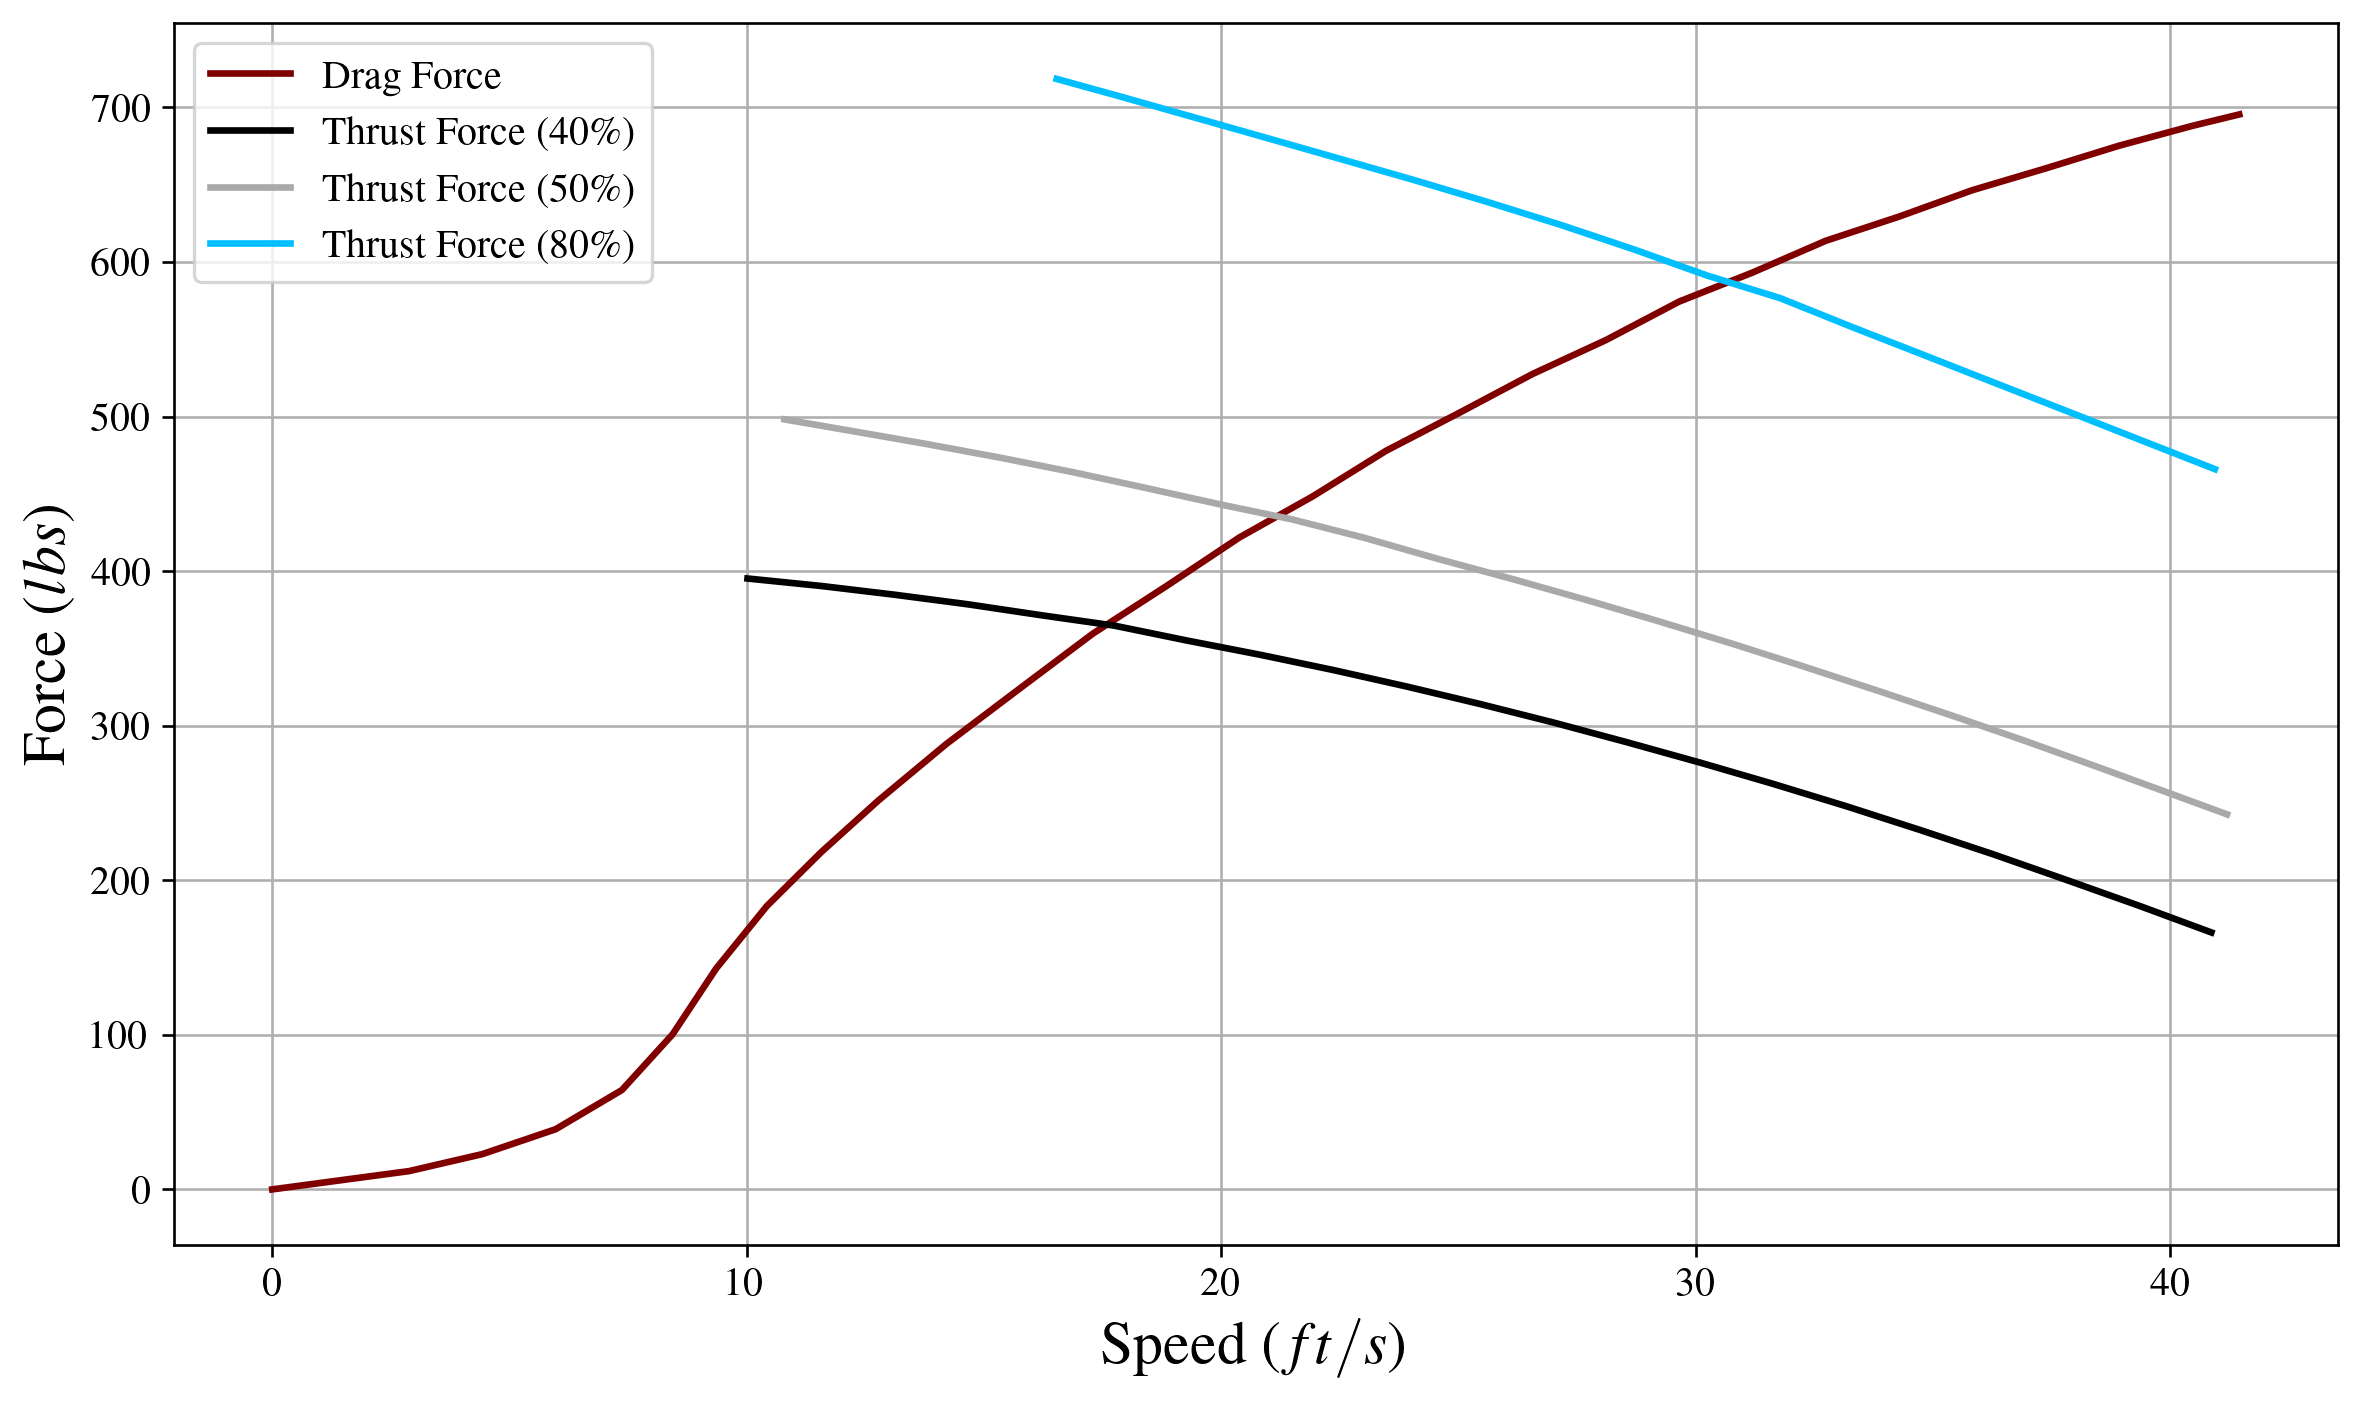

In [17]:
fig, ax = plt.subplots()
ax.plot(drag['speed'], drag['force'], label='Drag Force')
ax.plot(thrust_40['speed'], thrust_40['force'], label=r'Thrust Force (40\%)')
ax.plot(thrust_50['speed'], thrust_50['force'], label=r'Thrust Force (50\%)')
ax.plot(thrust_80['speed'], thrust_80['force'], label=r'Thrust Force (80\%)')
ax.set_xlabel('Speed ($ft/s$)')
ax.set_ylabel('Force ($lbs$)')
ax.legend()
plt.show()

# Problem 3
## Given
![Figure 2](fig2.png)

The image above shows the moment curve on a shaft with respect to varying angular velocities.

## Find
Estimate the maximum power $P_{max}$ the induction motor can deliver, and the associated torque $M$ and angular velocity $\dot{\theta}$. Also, find the ratio of this power to the power $P_{maxM}$ (power at maximum torque) delivered when the torque is maximized.

## Solution
We first need to convert the torque curve into a dataset.

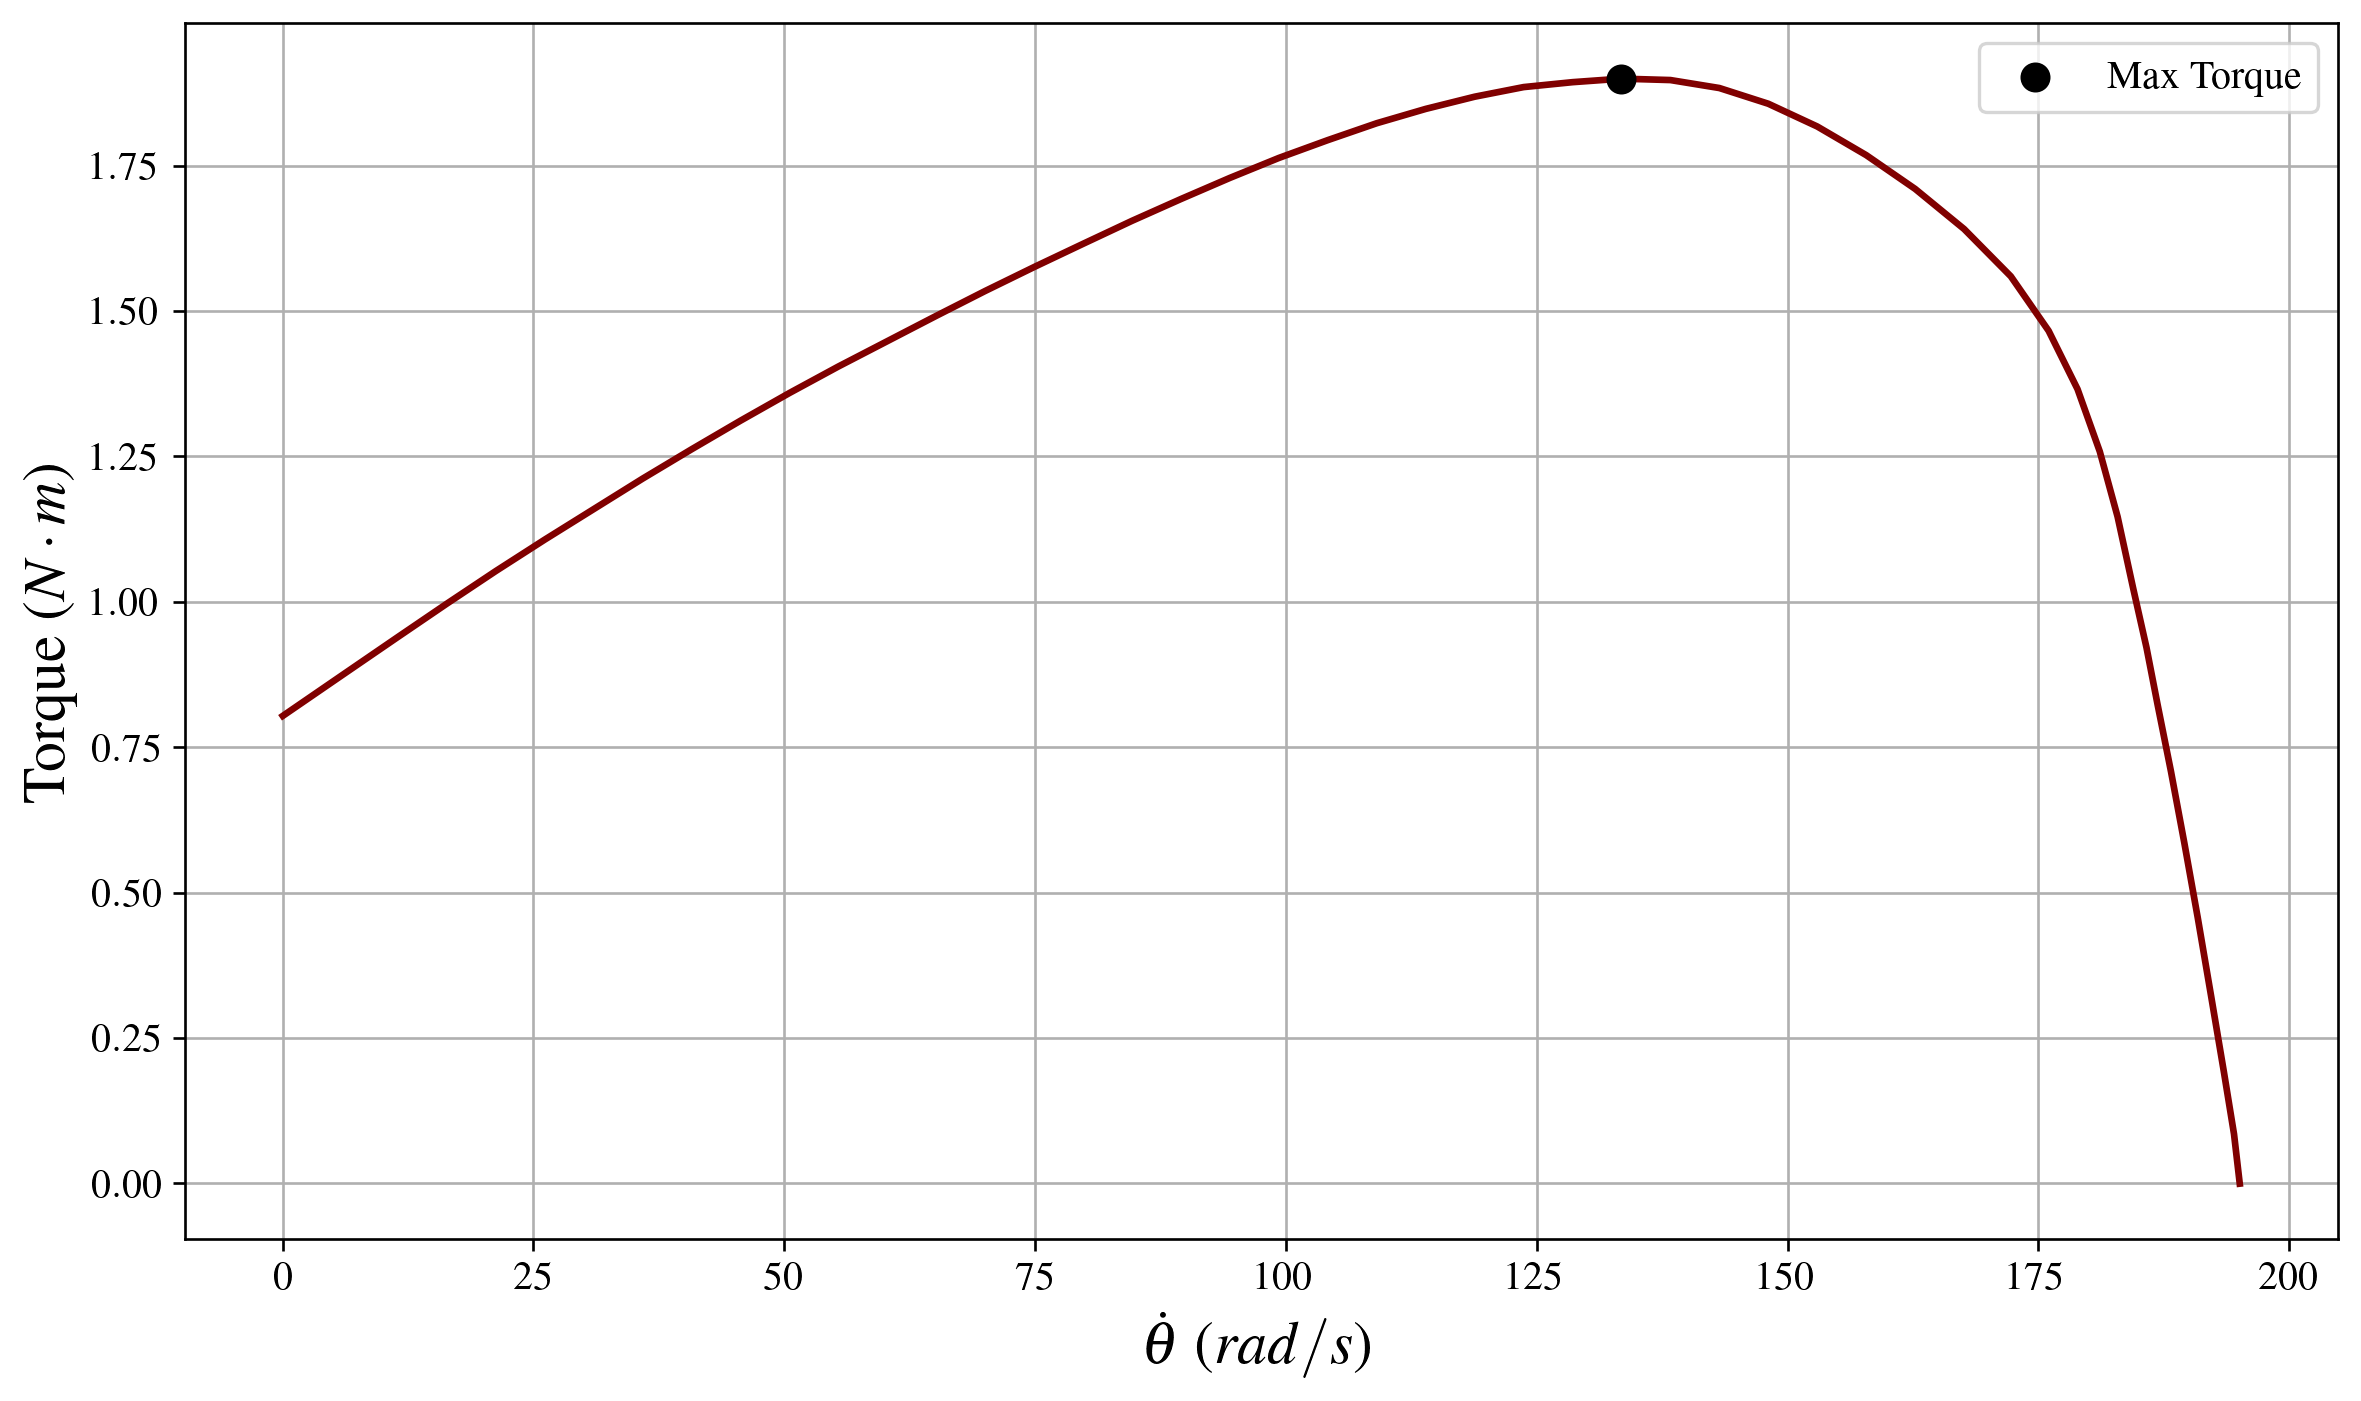

In [18]:
motor_data = pd.read_csv('motor_data.csv')

max_M = np.max(motor_data['M'])  # N*m
max_M_theta = np.array(motor_data['theta_dot'])[motor_data['M'] == max_M][0]

fig, ax = plt.subplots()
ax.plot(motor_data['theta_dot'], motor_data['M'])
ax.scatter(max_M_theta, max_M, color='black', label='Max Torque', zorder=3)
ax.set_xlabel(r'$\dot{\theta}$ ($rad/s$)')
ax.set_ylabel(r'Torque ($N\cdot m$)')
ax.legend()
plt.show()

For each point in the dataset, the power is

$$P=M\cdot\dot{\theta}$$

In [19]:
# Getting power
power = np.array(motor_data['M']*motor_data['theta_dot'])
P_max = np.max(power)
max_P_theta = np.array(motor_data['theta_dot'])[power == P_max][0]
P_max  # W

279.09391404004356

In [20]:
# Getting power at maximum torque
P_maxM = max_M*max_M_theta
P_maxM  # W

253.51556550997947

In [21]:
# Getting the ratio of the two
P_max/P_maxM

1.1008945879855934

## Verification
You can see the results are correct on the graph below.

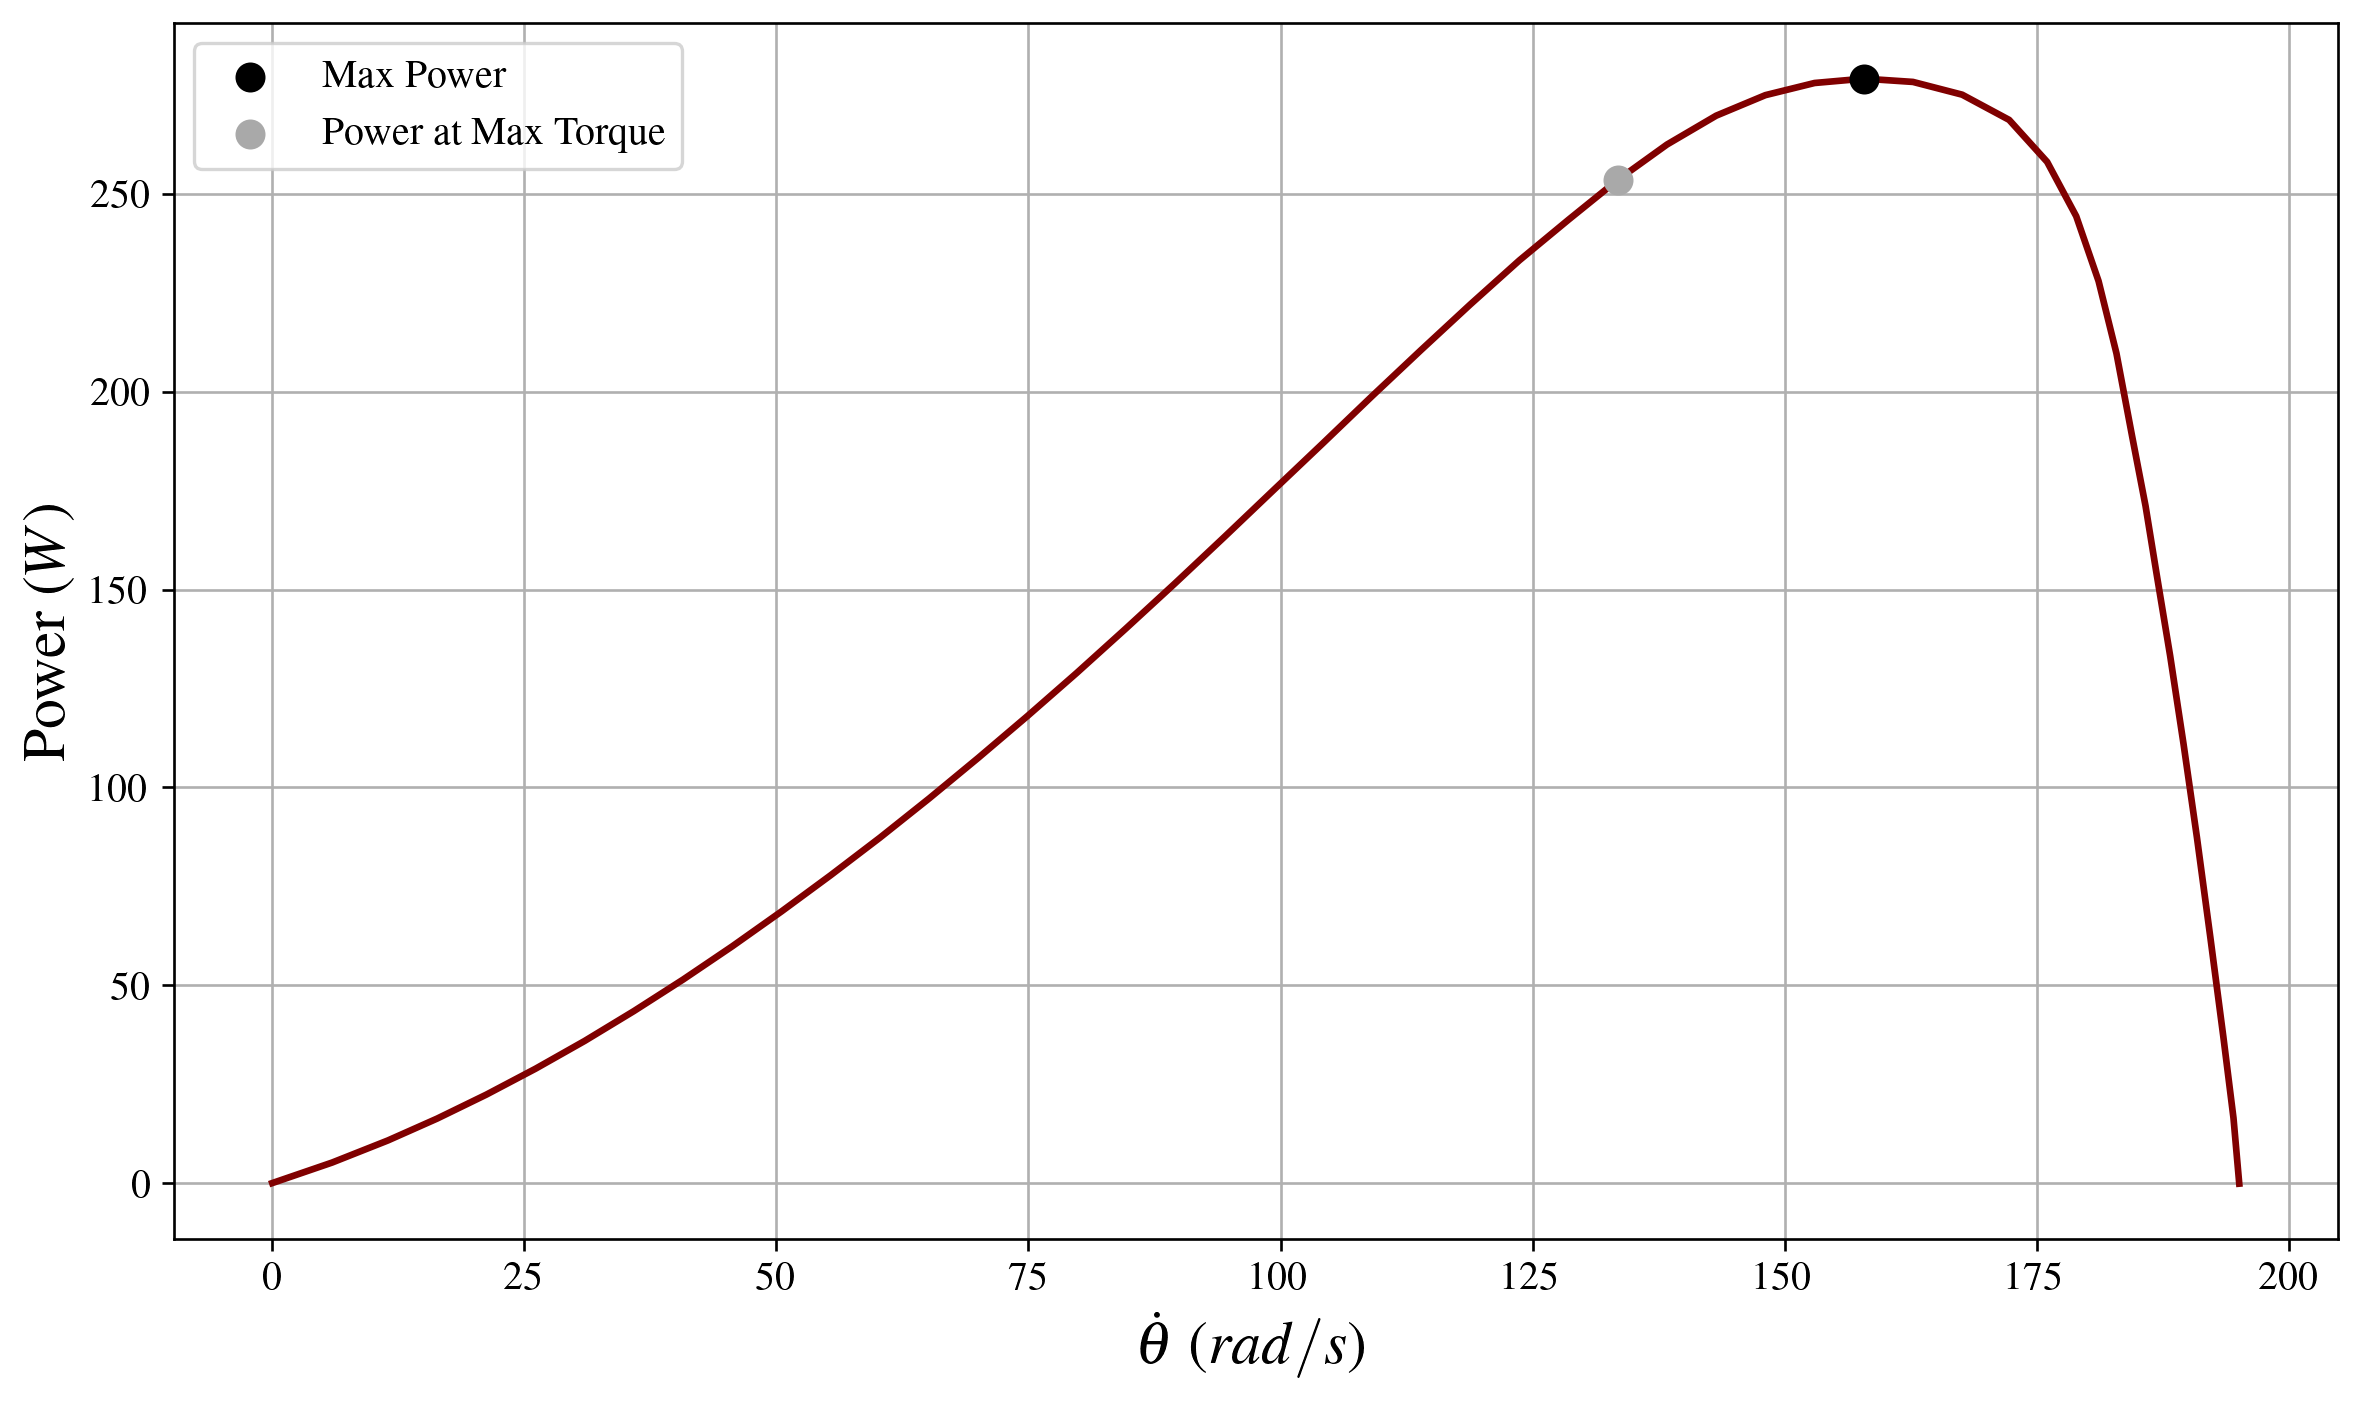

In [22]:
fig, ax = plt.subplots()
ax.plot(motor_data['theta_dot'], power)
ax.scatter(max_P_theta, P_max, color='black', label='Max Power', zorder=3)
ax.scatter(max_M_theta, P_maxM, color='darkgrey', label='Power at Max Torque', zorder=3)
ax.set_xlabel(r'$\dot{\theta}$ ($rad/s$)')
ax.set_ylabel('Power ($W$)')
ax.legend()
plt.show()

# Problem 4
## Given
![Figure 3](fig3.png)

![Figure 4](fig4.png)

The curves above indicate a similar system to the previous problem, but this time, there is a resistive torque acting on the motor shaft. The second image shows the twentieth floor resistive torque. The first image indicates the motor generated motor torque. This motor has a switching component that adds the ability to initiate a faster angular velocity, which adds stability at higher speeds. This can be thought of like a transmission in a car, changing the gear ratio to make certain speeds stable. The shaft has an equivalent inertia of 0.015 $kg\cdot m^2$.

## Find
a. Estimate the average net torque available for acceleration over the speed range $0<\dot{\phi}<100\ rad/s$.
b. Repeat (a) for the speed ranges $100 < \dot{\phi} < 130\ rad/s$ and $130 < \dot{\phi} < 150\ rad/s$.
c. Estimate the time required for the system to accelerate from rest to the switching speed of 150 rad/s.

## Solution
### Part A
We need to superimpose the motor torque curve ($M_m$) and the resistive fluid torque curve on the twentieth floor ($M_p$).

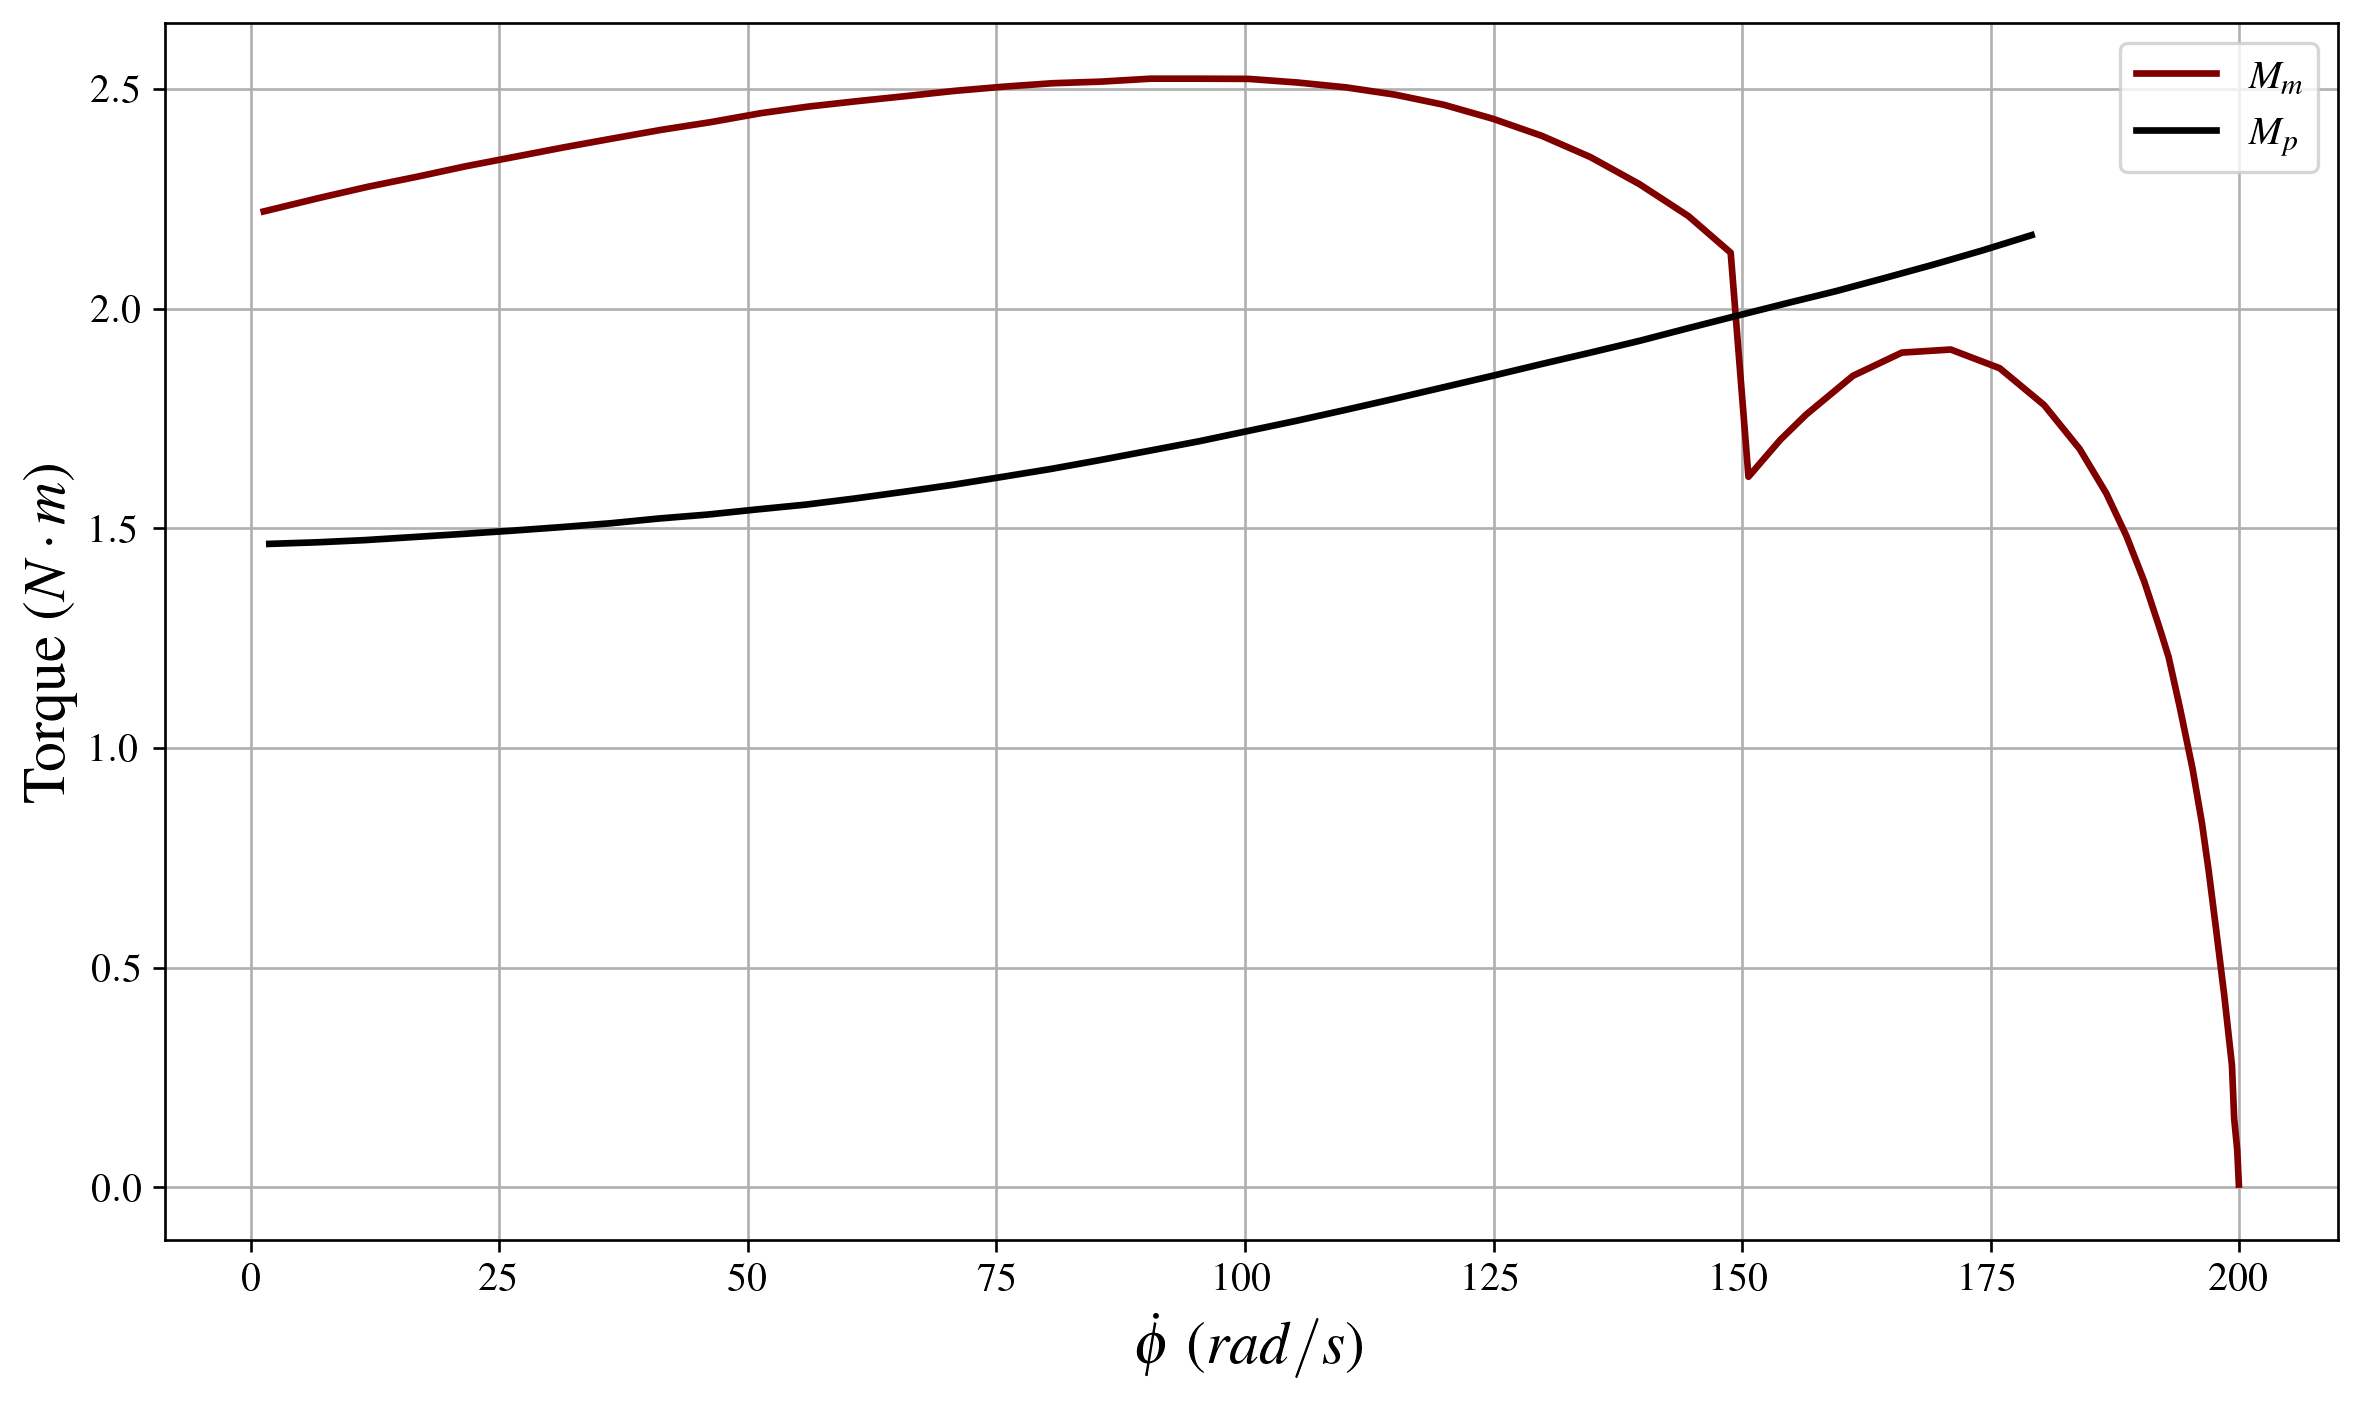

In [23]:
switch_motor = pd.read_csv('switching_motor_data.csv')
resistive_data = pd.read_csv('resistive_torque_20.csv')
phi_dot_Mp = np.array(resistive_data['phi_dot'])
Mp = np.array(resistive_data['Mp'])
phi_dot_Mm = np.array(switch_motor['phi_dot'])
Mm = np.array(switch_motor['Mm'])

fig, ax = plt.subplots()
ax.plot(phi_dot_Mm, Mm, label='$M_m$')
ax.plot(phi_dot_Mp, Mp, label='$M_p$')
ax.set_xlabel(r'$\dot{\phi}$ ($rad/s$)')
ax.set_ylabel(r'Torque ($N\cdot m$)')
ax.legend()
plt.show()

We need to determine the average net torque from 0 to 100 rad/s.

In [24]:
# We will perform the operations over the phi_dot_Mm array because the phi_dot sizes are not the same
Mp_func = interp1d(phi_dot_Mp, Mp, kind='linear', fill_value='extrapolate')

zero_to_100 = np.logical_and(phi_dot_Mm > 0, phi_dot_Mm < 100)
Mm_to_100 = Mm[zero_to_100]
phi_dot_Mm_to_100 = phi_dot_Mm[zero_to_100]

# Getting the net torque across this range
M_to_100 = Mm_to_100 - Mp_func(phi_dot_Mm_to_100)
M_mean_to_100 = np.mean(M_to_100)
M_mean_to_100  # N*m

0.85845336699358

### Part B
We can find the average net torque of 100 to 130 and 130 to 150 using the same procedure.

In [25]:
i2 = np.logical_and(phi_dot_Mm >= 100, phi_dot_Mm < 130)
Mm_2 = Mm[i2]
phi_dot_Mm_2 = phi_dot_Mm[i2]

# Computing the mean net torque from 100 to 130
M2 = Mm_2 - Mp_func(phi_dot_Mm_2)
M2_mean = np.mean(M2)
M2_mean  # N*m

0.6775943282803308

In [26]:
i3 = np.logical_and(phi_dot_Mm >= 130, phi_dot_Mm < 150)
Mm_3 = Mm[i3]
phi_dot_Mm_3 = phi_dot_Mm[i3]

# Computing the mean net torque from 130 to 150
M3 = Mm_3 - Mp_func(phi_dot_Mm_3)
M3_mean = np.mean(M3)
M3_mean  # N*m

0.3008080984842129

### Part C
The dynamics of this system is expressed by

$$M_{net}(\dot{\phi}) = I\frac{d\dot{\phi}}{dt}$$

This can be re-arranged to be

$$dt=I\left(\frac{1}{M_{net}(\dot{\phi})}\right)d\dot{\phi}$$

$$t=I\int^{150}_0\frac{1}{M_{net}(\dot{\phi})}d\dot{\phi}$$

We don't have the net moment as a function of $\dot{\phi}$, but we do have the discretized dataset. We can just take the reciprocal over the dataset and use the trapezoid rule to estimate the integral.

In [27]:
# Getting the net moment data set from 0 to 150
I = 0.015  # kg*m^2
i4 = np.where(phi_dot_Mm <= 150)
phi_dot_to_150 = phi_dot_Mm[i4]
Mm_to_150 = Mm[i4]

M_net_to_150 = Mm_to_150 - Mp_func(phi_dot_to_150)
area = np.trapz(1/M_net_to_150, phi_dot_to_150)
t_elapsed = I*area
t_elapsed  # s

3.324234091463819

## Verification
For parts (a) and (b), we can check the mean net torques by graphing it.

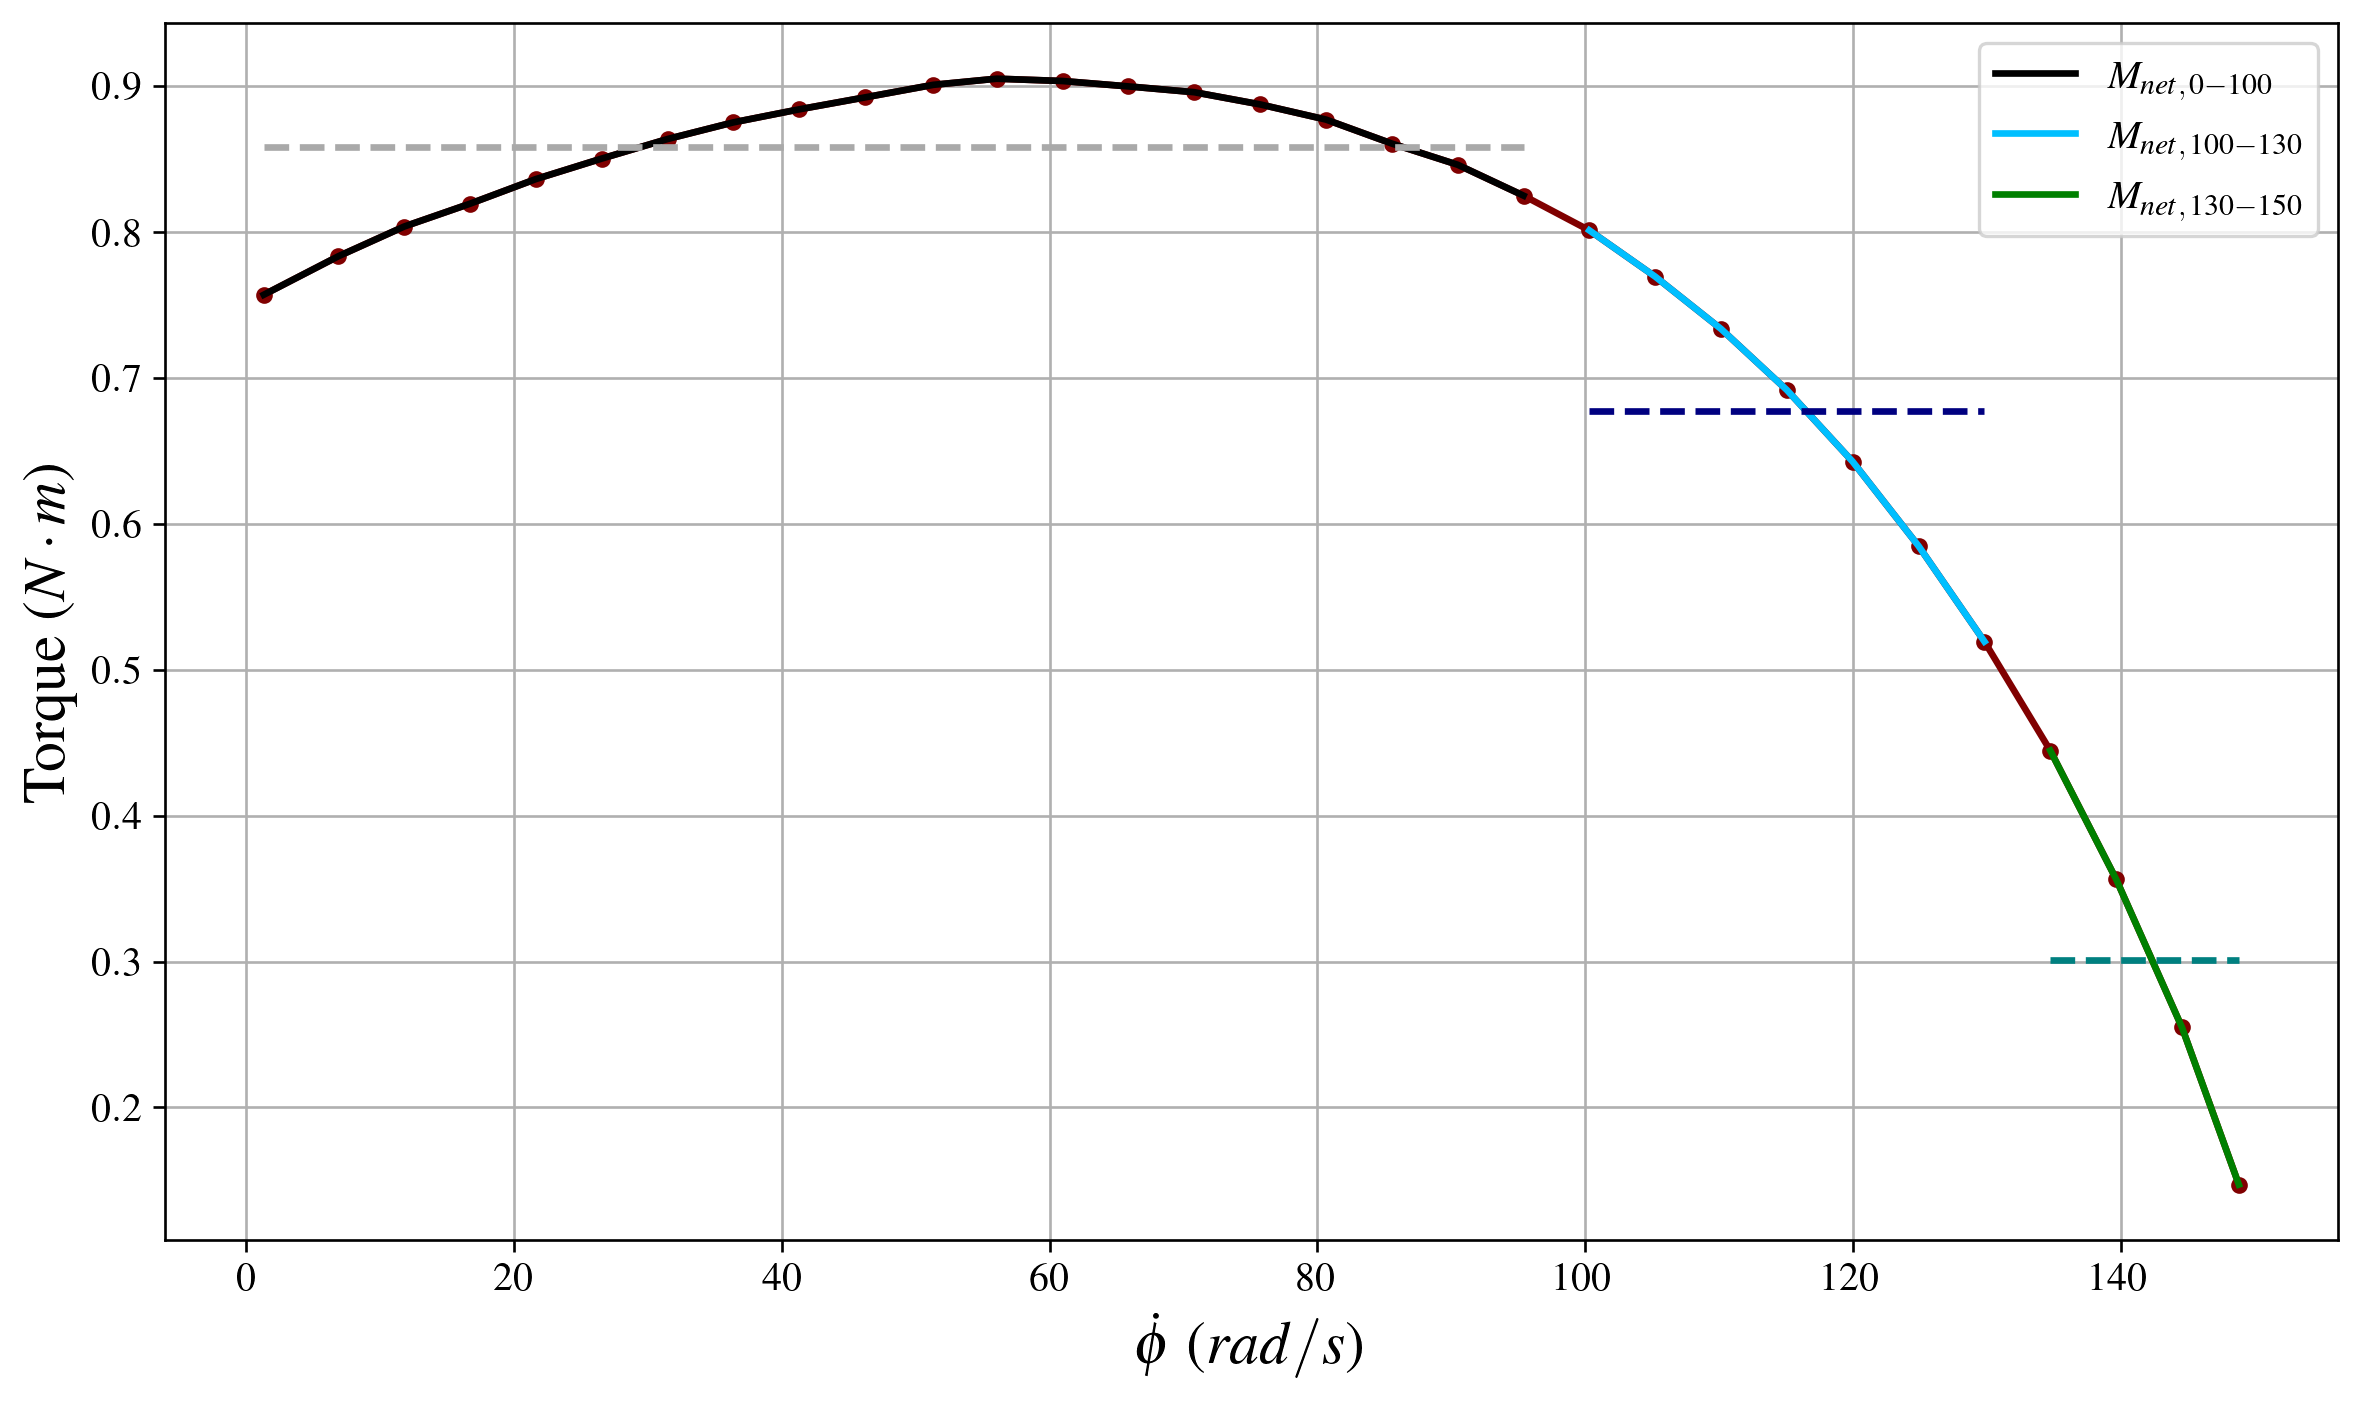

In [28]:
fig, ax = plt.subplots()
ax.plot(phi_dot_to_150, M_net_to_150, marker='.')
ax.plot(phi_dot_Mm_to_100, M_to_100, label=r'$M_{net,\,0-100}$')
ax.plot([phi_dot_Mm_to_100[0], phi_dot_Mm_to_100[-1]], [M_mean_to_100, M_mean_to_100], ls='--')
ax.plot(phi_dot_Mm_2, M2, label=r'$M_{net,\,100-130}$')
ax.plot([phi_dot_Mm_2[0], phi_dot_Mm_2[-1]], [M2_mean, M2_mean], ls='--')
ax.plot(phi_dot_Mm_3, M3, label=r'$M_{net,\,130-150}$')
ax.plot([phi_dot_Mm_3[0], phi_dot_Mm_3[-1]], [M3_mean, M3_mean], ls='--')
ax.set_xlabel(r'$\dot{\phi}$ ($rad/s$)')
ax.set_ylabel(r'Torque ($N\cdot m$)')
ax.legend()
plt.show()

As for verifying the elapsed time calculation, the average net mean should be equivalent to $I\cdot\frac{\Delta\dot{\phi}}{\Delta t}$.

In [29]:
I*(phi_dot_to_150[-1] - phi_dot_to_150[0])/t_elapsed  # N*m

0.6657136222702001

In [30]:
np.mean(M_net_to_150)

0.7456600010248634

The values aren't identical, but this is due to non-uniformity in the dataset. Nevertheless, the answers are in the ballpark.

# Problem 5
## Given
Consider an impeller pump with the following source curve

$$P_s(Q)=83 - 0.004901Q - 0.000324Q^2$$

This source drives a load with a load curve of $P_L(Q)=20 + 0.1Q$. In both the source and load curves pressure has units of psi and $Q$ has units of $\frac{in^3}{s}$.

## Find
a. Estimate the equilibrium pressure and flow.
b. Assuming the load can be changed arbitrarily, find the maximum power point on the source curve.

## Solution
### Part A
The equilibrium pressure and flow occurs when the pressure of the source and load curves are equal.

In [31]:
# Solving for the flow rates
Q = sp.Symbol('Q')
source = 83 - sp.S('0.004901')*Q - sp.S('0.000324')*Q**2
load = 20 + sp.S('0.1')*Q
eq = sp.Eq(source, load)
eq

Eq(-0.000324*Q**2 - 0.004901*Q + 83, 0.1*Q + 20)

In [32]:
Q_sol = sp.solve(eq)
Q_eq = Q_sol[1]
display(*Q_sol)  # in^3/s

-631.619246076681

307.850727558163

In [33]:
# Getting the pressure
source.subs(Q, Q_sol[0])  # psi

-43.1619246076681

In [34]:
P_eq = source.subs(Q, Q_sol[1])
P_eq  # psi

50.7850727558163

In the above calculations, there appears to be an equilibrium point at a negative flow rate. I am going to ignore negative flow rates and assume the fluid is flowing with the pump direction. Therefore, our equilibrium point is $Q=308\,\frac{in^3}{s}$, $P=50.8\,psi$.

### Part B
Power is

$$P=P_s\cdot Q$$

In [35]:
P = source*Q

# Finding the peak
dP_dQ = P.diff()
Q_sol_power = sp.solve(dP_dQ)
Q_peak = Q_sol_power[1]
display(*Q_sol_power)  # in^3/s

-297.302972302720

287.218610162803

In [36]:
# Only use the positive value
P.subs(Q, Q_sol_power[1])  # lbf*in/s

15757.9945317928

In [37]:
P_peak = P.subs(Q, Q_sol_power[1])/6600
P_peak # hp (peak source power)

2.38757492905951

As seen above, the peak power is $2.39\,hp$ at $287\,\frac{in^3}{s}$.

## Verification
Here are the plots.

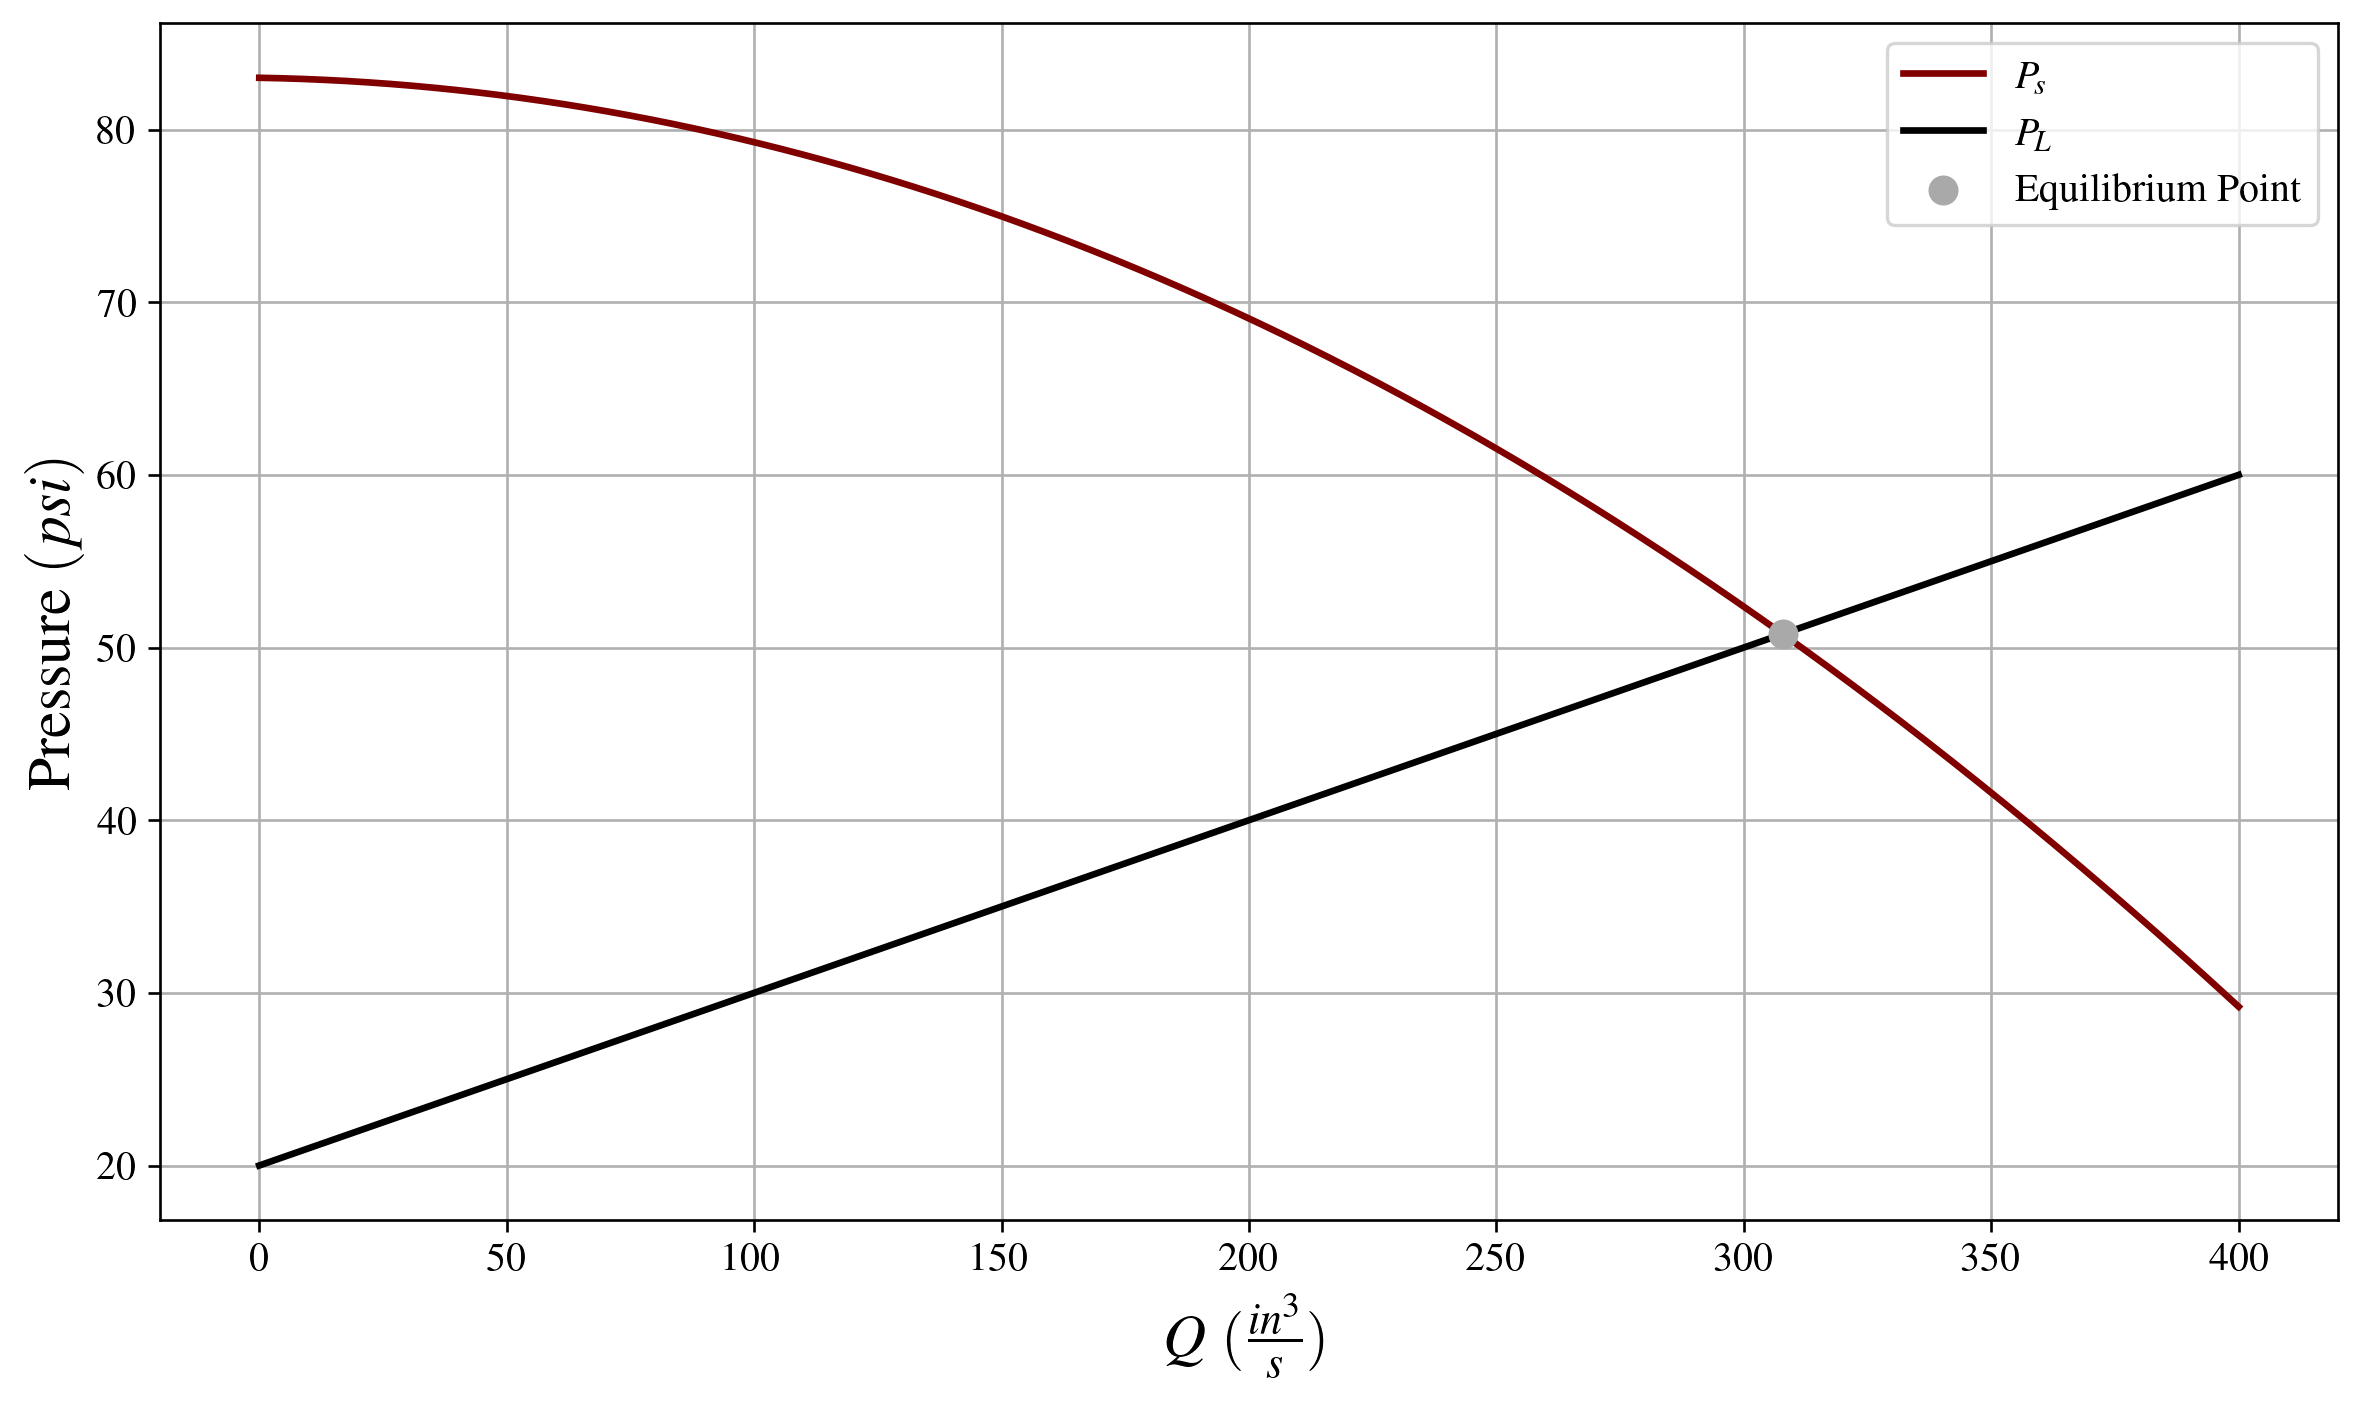

In [38]:
Ps = sp.lambdify(Q, source, modules='numpy')
PL = sp.lambdify(Q, load, modules='numpy')
Q_array = np.linspace(0, 400, 1000)

plt.plot(Q_array, Ps(Q_array), label='$P_s$')
plt.plot(Q_array, PL(Q_array), label='$P_L$')
plt.scatter(float(Q_eq), float(P_eq), zorder=3, color='darkgrey', label="Equilibrium Point")
plt.xlabel(r'$Q\ (\frac{in^3}{s})$')
plt.ylabel('Pressure $(psi)$')
plt.legend()
plt.show()

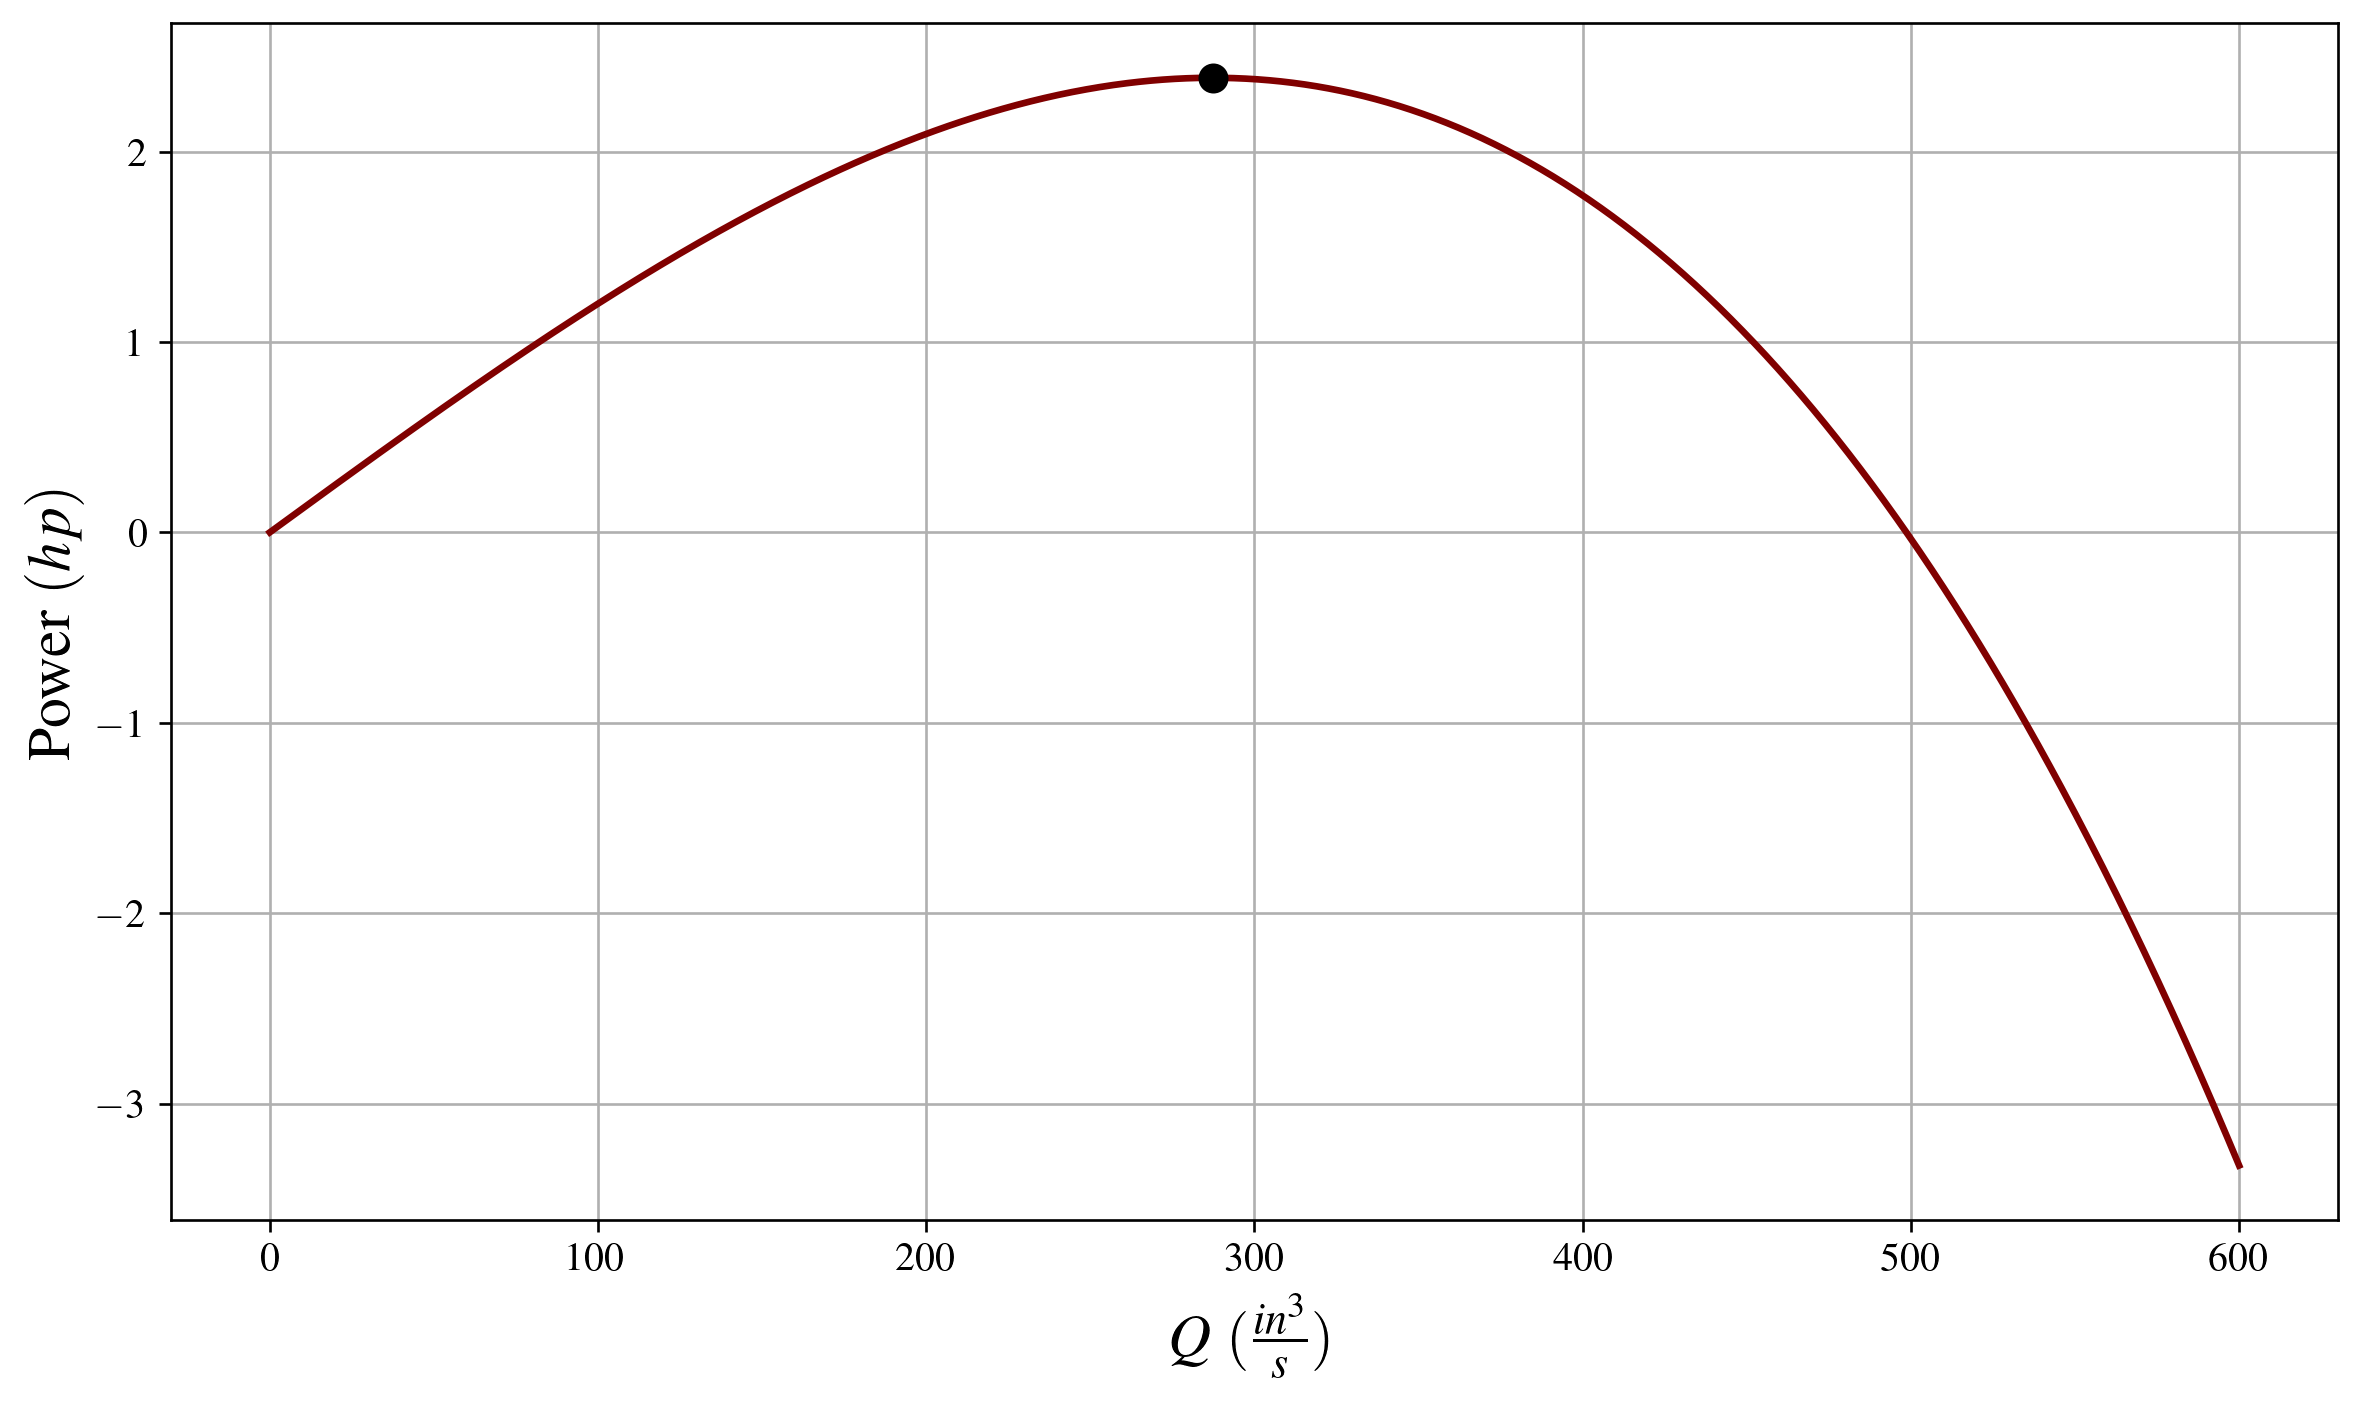

In [39]:
P_lamb = sp.lambdify(Q, P, modules='numpy')
Q_power = np.linspace(0, 600, 1000)

plt.plot(Q_power, P_lamb(Q_power)/6600)
plt.scatter(float(Q_peak), float(P_peak), zorder=3, color='black')
plt.xlabel(r'$Q\ (\frac{in^3}{s})$')
plt.ylabel(r'Power $(hp)$')
plt.show()

The peak power and equilibrium points align with the calculated values.